In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, avg, sum, min, max, lit, datediff, to_date, year, month, dayofweek,array,when,lower,mean,stddev
from pyspark.sql.functions import size as array_size, from_json, array, when, lit, coalesce
from pyspark.sql.functions import isnan, when, count, round, lag, percentile_approx, expr, udf, collect_list,desc,quarter
from pyspark.sql.types import IntegerType, FloatType, ArrayType, StringType, TimestampType,MapType,DoubleType,size,StructType,ShortType
from pyspark.ml.feature import StringIndexer
from pyspark.sql.window import Window
import json
from scipy import stats
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from matplotlib.colors import LinearSegmentedColormap
import calendar
from wordcloud import WordCloud
import math
from datetime import datetime 

In [2]:
# 创建Spark会话（启用内存优化）
spark = SparkSession.builder \
    .appName("UserProfileAnalysis") \
    .config("spark.sql.files.maxPartitionBytes", "128m") \
    .config("spark.executor.memory", "64g") \
    .config("spark.driver.memory", "64g") \
    .config("spark.sql.shuffle.partitions", "800") \
    .config("spark.default.parallelism", "800")   \
    .config("spark.memory.offHeap.enabled", "true") \
    .config("spark.memory.offHeap.size", "8g") \
    .config("spark.memory.fraction", "0.8") \
    .config("spark.memory.storageFraction", "0.3") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.minPartitionSize", "500") \
    .config("spark.dynamicAllocation.enabled", "true") \
    .config("spark.driver.host", "10.0.14.11") \
    .config("spark.dynamicAllocation.maxExecutors", "100")  \
    .config("spark.executor.memoryOverhead", "8g") \
    .config("spark.log.level","ERROR") \
    .getOrCreate()

25/04/18 16:58:08 WARN Utils: Your hostname, roo-NF5468M6 resolves to a loopback address: 127.0.1.1; using 10.0.14.11 instead (on interface ens121f0np0)
25/04/18 16:58:08 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/18 16:58:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting Spark log level to "ERROR".


In [3]:
# 定义数据路径
data_dir = "./data/10G_data_new/"

# 创建输出目录
output_dir = "data_analysis_results"
os.makedirs(output_dir, exist_ok=True)

# 设置可视化风格
sns.set(style="whitegrid", palette="muted", font_scale=1.2)
PLOT_COLORS = ["#4e79a7", "#f28e2c", "#e15759", "#76b7b2", "#59a14f", "#edc949", "#af7aa1", "#ff9da7", "#9c755f", "#bab0ab"]

# 加载数据
print("加载数据集...")
df = spark.read.parquet(data_dir)

# 数据预处理
print("开始数据预处理...")

sample_df = df.limit(5)  
sample_df.show(truncate=False)  
# 转换日期字段为日期类型
df = df.withColumn("registration_date", to_date(col("registration_date")))
df = df.withColumn("last_login", to_date(col("last_login")))

# 解析JSON字段 - 购买历史和登录历史的UDF
def parse_purchase_history(purchase_json):
    if not purchase_json or purchase_json == "null" or purchase_json == "":
        return []
    try:
        purchase_data = json.loads(purchase_json)
        # 从JSON对象中提取items数组
        if isinstance(purchase_data, dict) and "items" in purchase_data:
            return purchase_data["items"]
        return []
    except:
        return []
        
def parse_login_history(login_json):
    if not login_json or login_json == "null" or login_json == "":
        return []
    try:
        login_data = json.loads(login_json)
        # 提取timestamps数组作为登录历史
        if isinstance(login_data, dict) and "timestamps" in login_data:
            return login_data["timestamps"]
        return []
    except:
        return []

# 计算购买次数的函数
def count_purchases(purchase_array):
    if not purchase_array:
        return 0
    return len(purchase_array)
def count_logins(login_array):
    if not login_array:
        return 0
    return len(login_array)

parse_purchase_udf = udf(parse_purchase_history, ArrayType(MapType(StringType(), StringType())))
count_purchases_udf = udf(count_purchases, IntegerType())

parse_login_udf = udf(parse_login_history, ArrayType(StringType()))
count_logins_udf = udf(count_logins, IntegerType())

# 应用UDF解析购买历史和登录历史
df = df.withColumn("purchase_history_parsed", parse_purchase_udf(col("purchase_history")))
df = df.withColumn("purchase_count", count_purchases_udf(col("purchase_history_parsed")))

df = df.withColumn("login_history_parsed", parse_login_udf(col("login_history")))
df = df.withColumn("login_count", count_logins_udf(col("login_history_parsed")))

# 创建临时视图便于SQL查询
df.createOrReplaceTempView("user_profiles")



加载数据集...


开始数据预处理...


+--------+-------------------------+---------+--------+--------------------+---+---------+------+--------+-------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+-----------------+-----------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|id      |last_login               |user_name|fullname|e

In [4]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "SimHei"   # 指定中文字体
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示异常


开始单变量分析...

1. 分析数值型变量...

分析年龄分布...


年龄分析结果：
- 平均年龄: 59.00
- 最小年龄: 18
- 最大年龄: 100
- 中位年龄: 59


- 年龄偏度: 0.0000
- 年龄峰度: -1.2003


Matplotlib is building the font cache; this may take a moment.



分析收入分布...


收入分析结果：
- 平均收入: 499997.10
- 最小收入: 0.01
- 最大收入: 999999.99
- 中位收入: 499914.65
- 99.9%分位收入: 998979.63


- 收入为负值的数量: 0
- 极端高收入数量 (>99.9%分位数): 46445


- 收入基尼系数: 0.3334


/tmp/ipykernel_1347337/1050767896.py:137: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f"{output_dir}/income_lorenz_curve.png", dpi=300, bbox_inches="tight")


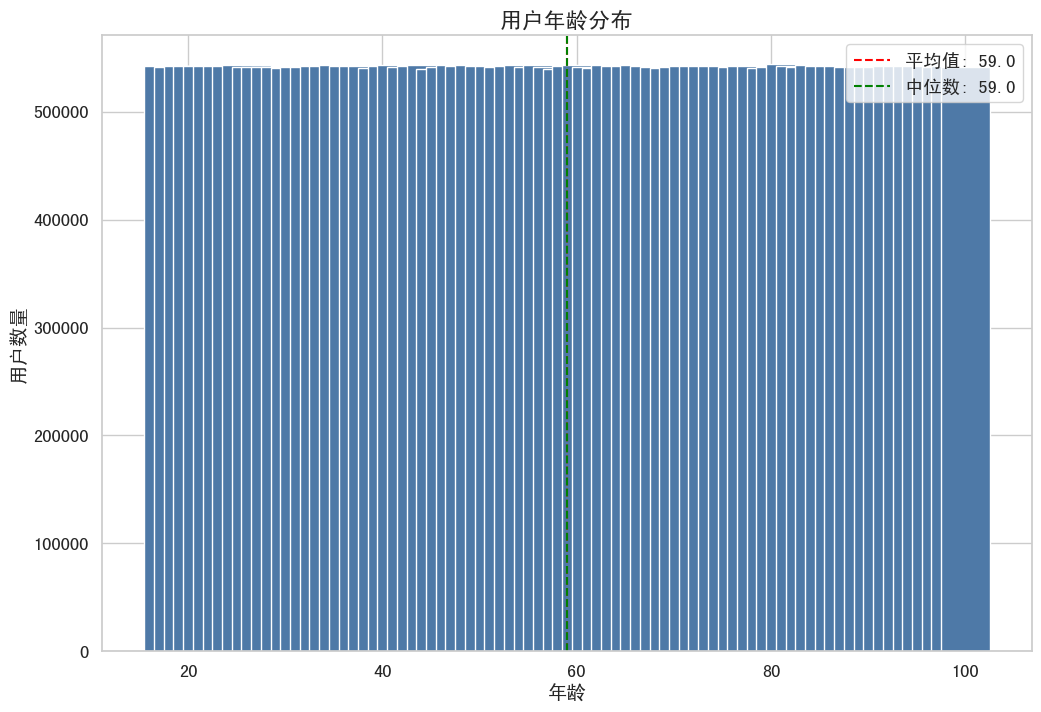

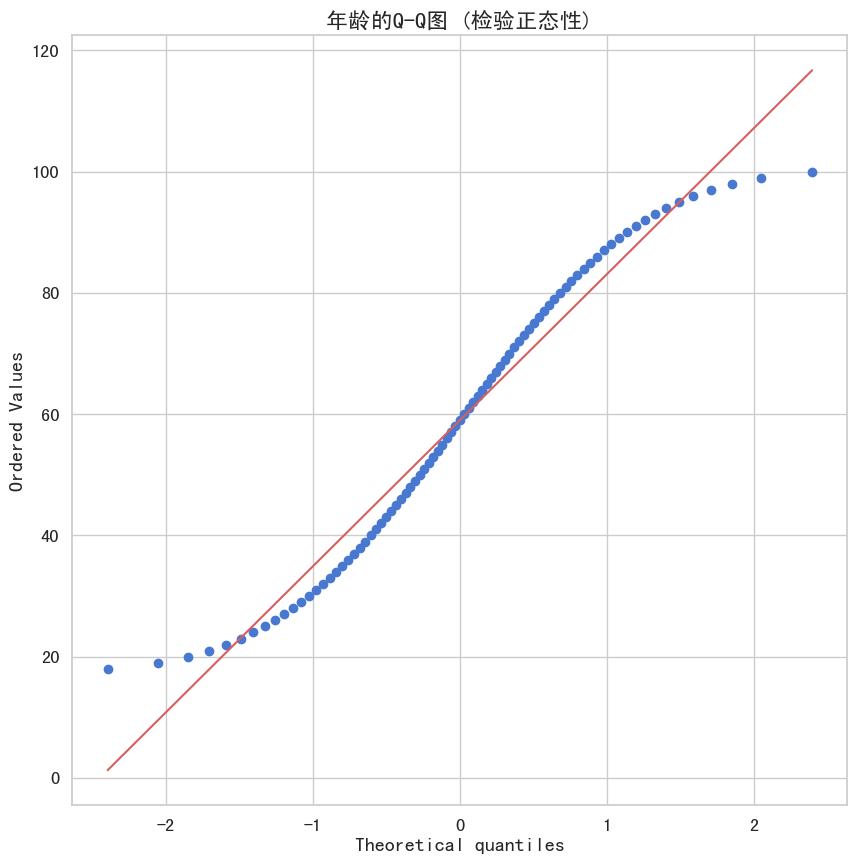

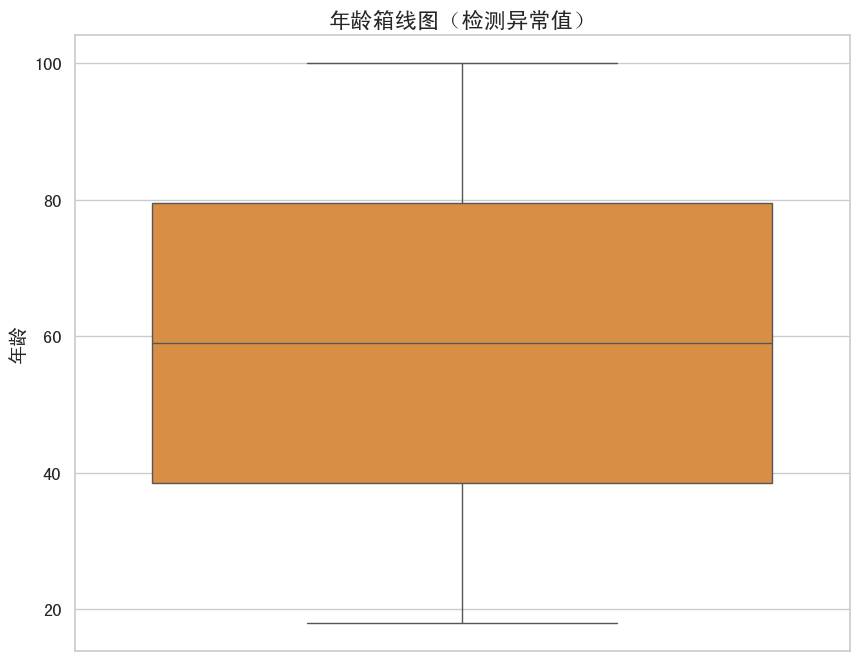

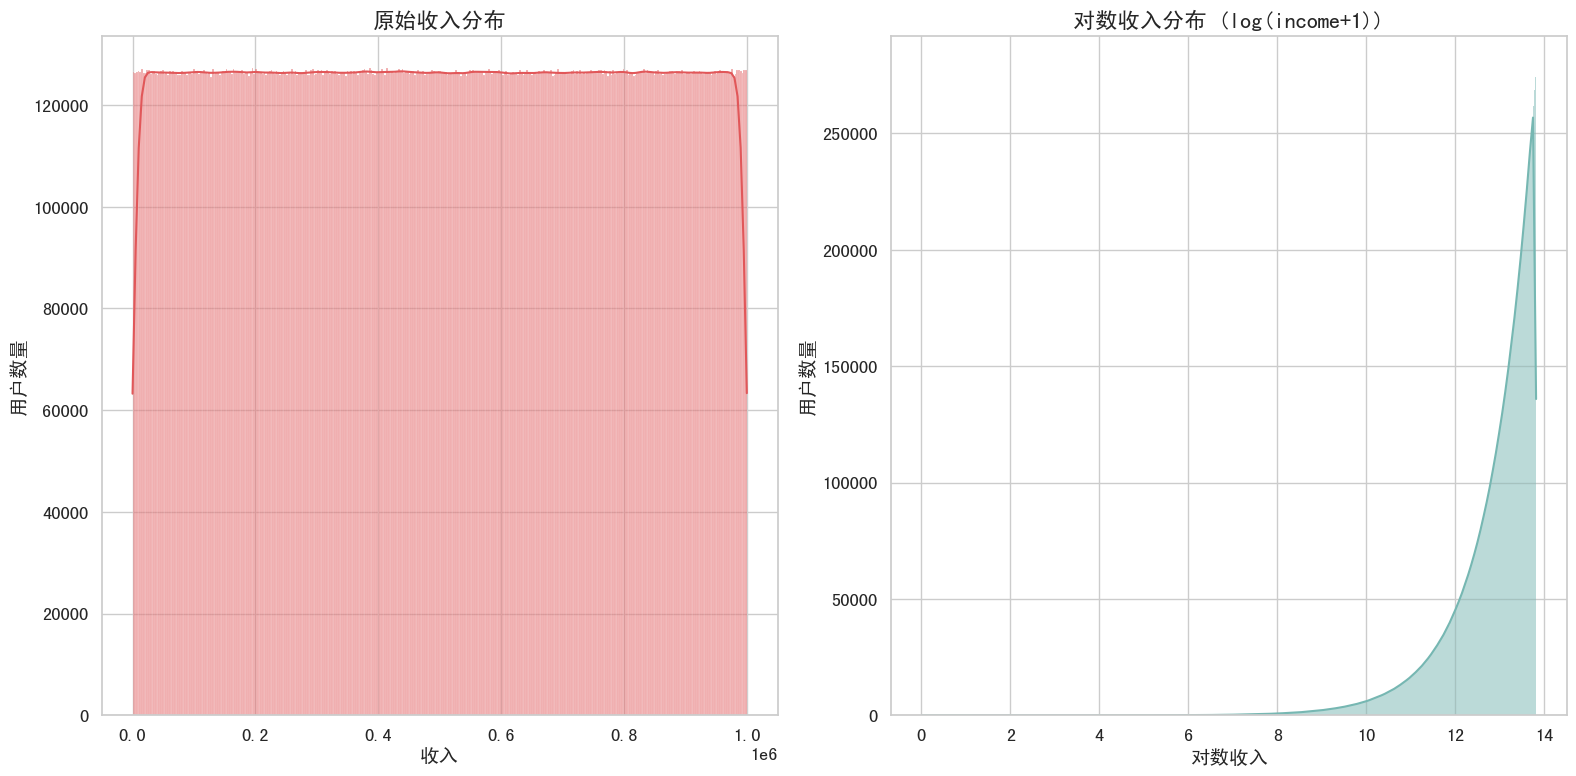

/home/roo/anaconda3/envs/work/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


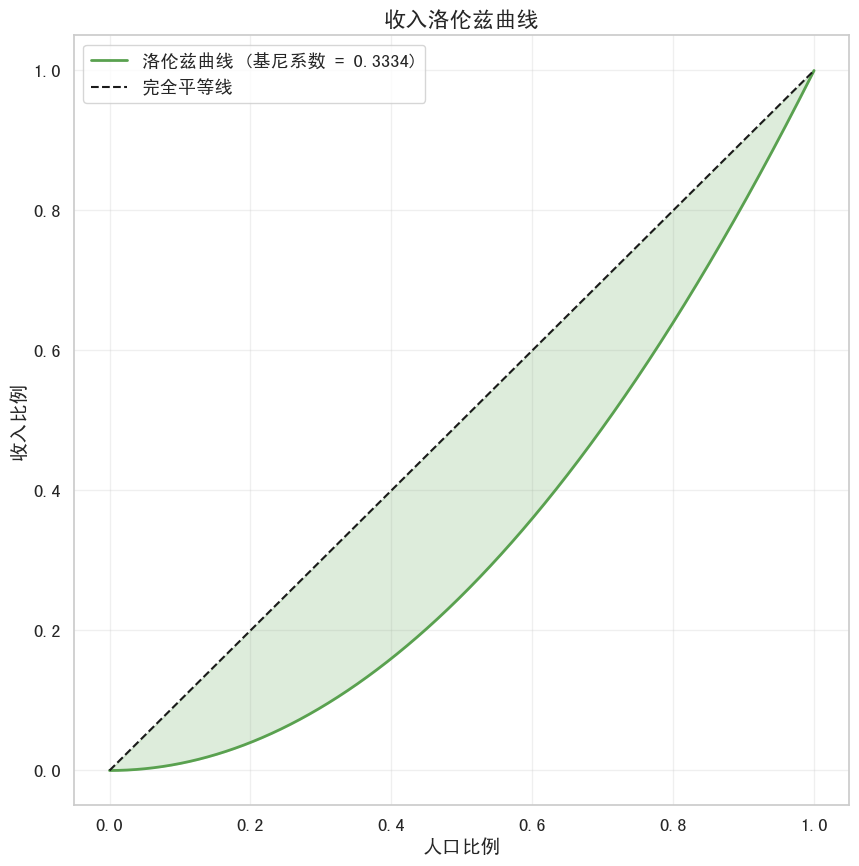

In [ ]:
# 1.1 单变量分析
# =====================================================================
print("\n开始单变量分析...")

# 1.1.1 数值型变量分析
print("\n1. 分析数值型变量...")

# ---- 年龄分析 ----
print("\n分析年龄分布...")

# 基本统计信息
age_stats = df.select(
    avg("age").alias("平均年龄"),
    min("age").alias("最小年龄"),
    max("age").alias("最大年龄"),
    expr("percentile_approx(age, 0.5)").alias("中位年龄"),
    expr("percentile_approx(age, array(0.25, 0.75))").alias("年龄四分位数")
).collect()[0]

print(f"年龄分析结果：")
print(f"- 平均年龄: {age_stats['平均年龄']:.2f}")
print(f"- 最小年龄: {age_stats['最小年龄']}")
print(f"- 最大年龄: {age_stats['最大年龄']}")
print(f"- 中位年龄: {age_stats['中位年龄']}")


# 转换为Pandas进行可视化
age_distribution = df.groupBy("age").count().orderBy("age").toPandas()

# 计算偏度和峰度
age_skew = stats.skew(age_distribution["age"].dropna())
age_kurtosis = stats.kurtosis(age_distribution["age"].dropna())
print(f"- 年龄偏度: {age_skew:.4f}")
print(f"- 年龄峰度: {age_kurtosis:.4f}")

# 绘制年龄直方图
plt.figure(figsize=(12, 8))
plt.bar(age_distribution["age"], age_distribution["count"], width=5, color=PLOT_COLORS[0])
plt.title("用户年龄分布", fontsize=16)
plt.xlabel("年龄", fontsize=14)
plt.ylabel("用户数量", fontsize=14)
plt.axvline(age_distribution["age"].dropna().mean(), color='red', linestyle='--', label=f"平均值: {age_distribution['age'].dropna().mean():.1f}")
plt.axvline(age_distribution["age"].dropna().median(), color='green', linestyle='--', label=f"中位数: {age_distribution['age'].dropna().median():.1f}")
plt.legend()
plt.savefig(f"{output_dir}/age_distribution.png", dpi=300, bbox_inches="tight")

# 绘制年龄Q-Q图检验正态性
plt.figure(figsize=(10, 10))
stats.probplot(age_distribution["age"].dropna(), dist="norm", plot=plt)
plt.title("年龄的Q-Q图 (检验正态性)", fontsize=16)
plt.savefig(f"{output_dir}/age_qq_plot.png", dpi=300, bbox_inches="tight")

# 绘制年龄箱线图（异常值检测）
plt.figure(figsize=(10, 8))
sns.boxplot(y=age_distribution["age"].dropna(), color=PLOT_COLORS[1])
plt.title("年龄箱线图（检测异常值）", fontsize=16)
plt.ylabel("年龄", fontsize=14)
plt.savefig(f"{output_dir}/age_boxplot.png", dpi=300, bbox_inches="tight")

# ---- 收入分析 ----
print("\n分析收入分布...")

# 基本统计信息
income_stats = df.select(
    avg("income").alias("平均收入"),
    min("income").alias("最小收入"),
    max("income").alias("最大收入"),
    expr("percentile_approx(income, 0.5)").alias("中位收入"),
    expr("percentile_approx(income, array(0.25, 0.75))").alias("收入四分位数"),
    expr("percentile_approx(income, 0.999)").alias("99.9%分位数")
).collect()[0]

print(f"收入分析结果：")
print(f"- 平均收入: {income_stats['平均收入']:.2f}")
print(f"- 最小收入: {income_stats['最小收入']}")
print(f"- 最大收入: {income_stats['最大收入']}")
print(f"- 中位收入: {income_stats['中位收入']}")
print(f"- 99.9%分位收入: {income_stats['99.9%分位数']}")

# 异常值检测 - 业务逻辑
income_negative = df.filter(col("income") < 0).count()
income_extreme = df.filter(col("income") > income_stats["99.9%分位数"]).count()
print(f"- 收入为负值的数量: {income_negative}")
print(f"- 极端高收入数量 (>99.9%分位数): {income_extreme}")

# 转换为Pandas进行可视化
income_distribution = df.select("income").toPandas()

# 计算基尼系数
def gini_coefficient(x):
    x = x.dropna().sort_values().values
    n = len(x)
    if n == 0:
        return None
    cumx = np.cumsum(x)
    return (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n

gini = gini_coefficient(income_distribution["income"])
print(f"- 收入基尼系数: {gini:.4f}")

# 绘制原始收入和对数收入的分布对比
income_distribution["log_income"] = np.log1p(income_distribution["income"])

plt.figure(figsize=(16, 8))

# 原始收入分布
plt.subplot(1, 2, 1)
sns.histplot(income_distribution["income"].dropna(), kde=True, color=PLOT_COLORS[2])
plt.title("原始收入分布", fontsize=16)
plt.xlabel("收入", fontsize=14)
plt.ylabel("用户数量", fontsize=14)

# 对数变换后的收入分布
plt.subplot(1, 2, 2)
sns.histplot(income_distribution["log_income"].dropna(), kde=True, color=PLOT_COLORS[3])
plt.title("对数收入分布 (log(income+1))", fontsize=16)
plt.xlabel("对数收入", fontsize=14)
plt.ylabel("用户数量", fontsize=14)

plt.tight_layout()
plt.savefig(f"{output_dir}/income_distribution.png", dpi=300, bbox_inches="tight")

# 洛伦兹曲线（用于可视化收入不平等）
plt.figure(figsize=(10, 10))
income_sorted = np.sort(income_distribution["income"].dropna().values)
population = np.arange(1, len(income_sorted) + 1) / len(income_sorted)
income_cum = np.cumsum(income_sorted) / np.sum(income_sorted)

plt.plot(population, income_cum, label=f"洛伦兹曲线 (基尼系数 = {gini:.4f})", color=PLOT_COLORS[4], linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label="完全平等线")
plt.fill_between(population, income_cum, population, color=PLOT_COLORS[4], alpha=0.2)
plt.xlabel("人口比例", fontsize=14)
plt.ylabel("收入比例", fontsize=14)
plt.title("收入洛伦兹曲线", fontsize=16)
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(f"{output_dir}/income_lorenz_curve.png", dpi=300, bbox_inches="tight")



2. 分析分类变量...

分析性别分布...


性别分布：
- 男: 21,603,397 (48.01%)
- 女: 21,598,086 (48.00%)
- 未指定: 899,652 (2.00%)
- 其他: 898,865 (2.00%)


- 性别缺失值: 0 (0.00%)

分析国家分布...


国家分布：
- 英国: 4,501,669 (10.00%)
- 法国: 4,501,427 (10.00%)
- 美国: 4,501,158 (10.00%)
- 巴西: 4,500,526 (10.00%)
- 德国: 4,500,370 (10.00%)
- 印度: 4,499,562 (10.00%)
- 俄罗斯: 4,499,132 (10.00%)
- 澳大利亚: 4,499,124 (10.00%)
- 日本: 4,498,695 (10.00%)
- 中国: 4,498,337 (10.00%)

分析用户活跃状态...


用户活跃状态：
- 非活跃: 22,501,308 (50.00%)
- 活跃: 22,498,692 (50.00%)



各国活跃率：
- 英国: 49.98%
- 法国: 49.98%
- 美国: 50.02%
- 巴西: 50.03%
- 德国: 49.99%
- 印度: 50.01%
- 俄罗斯: 50.00%
- 澳大利亚: 49.99%
- 日本: 49.98%
- 中国: 50.00%


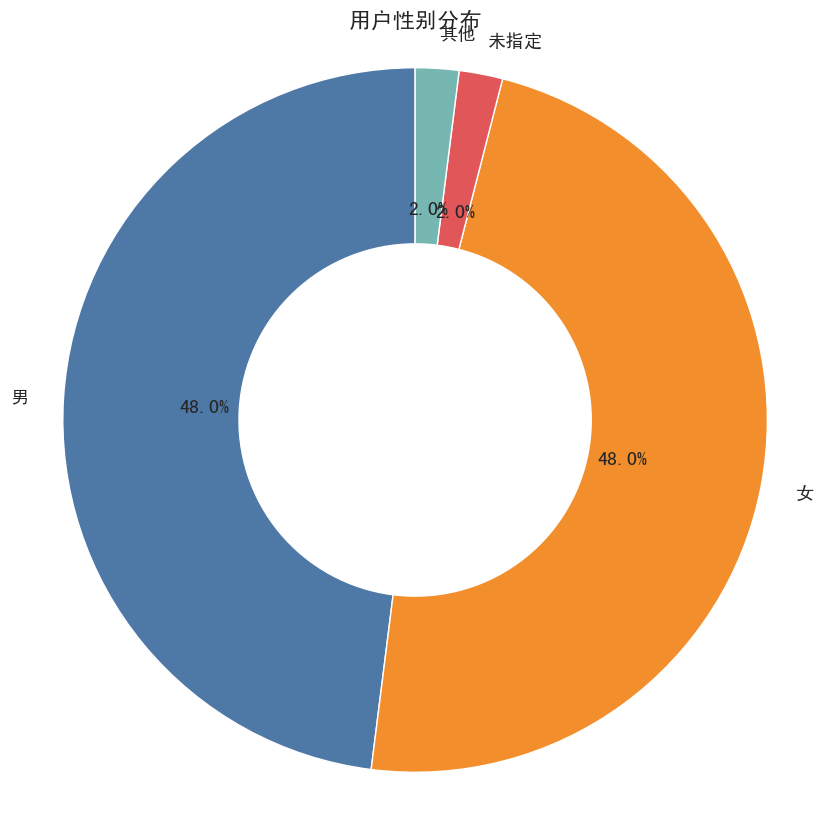

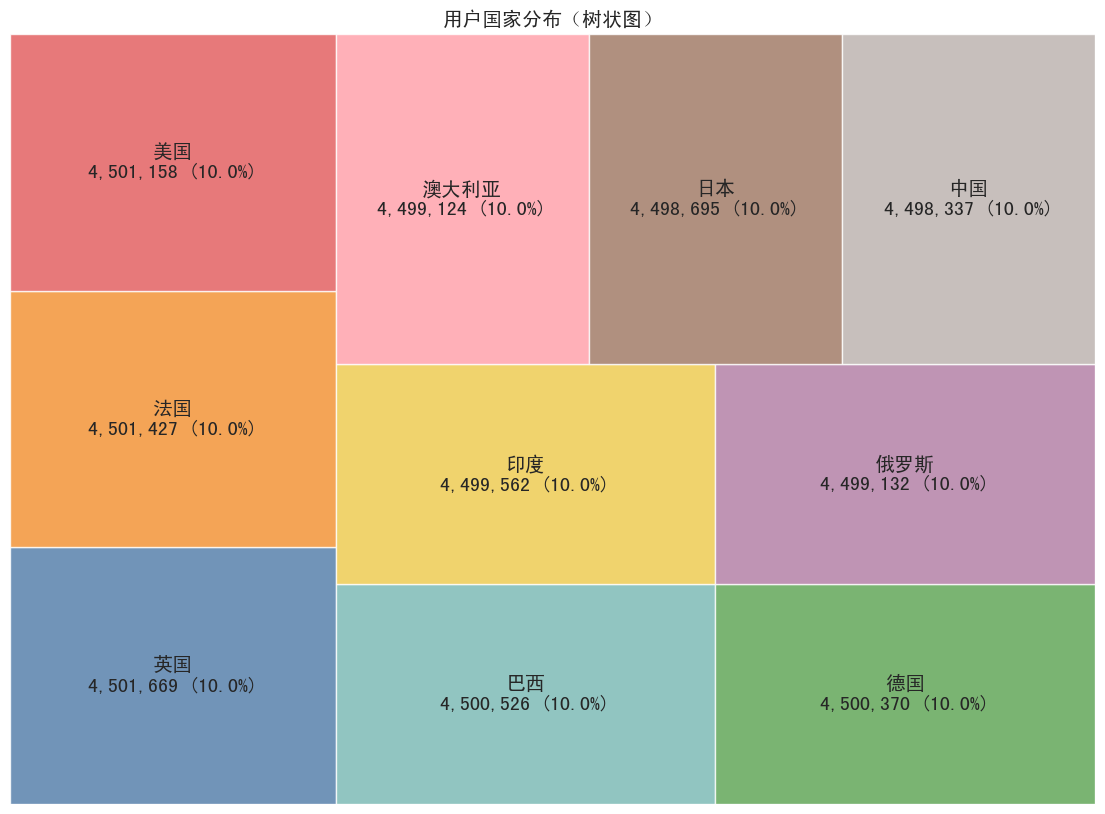

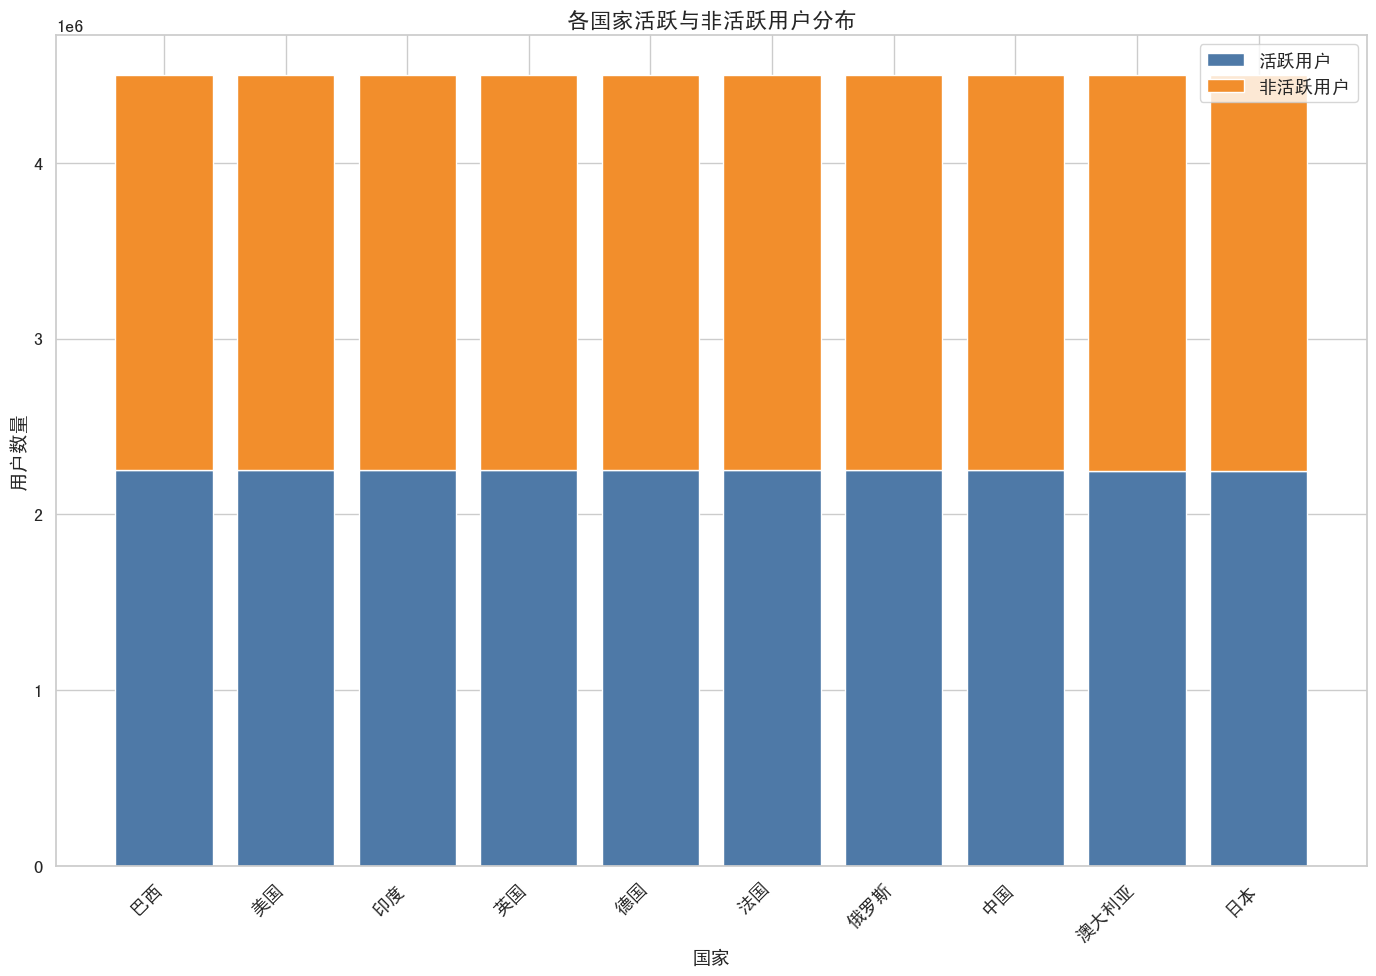

In [5]:
# 1.1.2 分类变量分析
print("\n2. 分析分类变量...")

# ---- 性别分析 ----
print("\n分析性别分布...")

gender_counts = df.groupBy("gender").count().orderBy("count", ascending=False).toPandas()
gender_total = gender_counts["count"].sum()
gender_counts["percentage"] = gender_counts["count"] / gender_total * 100

print("性别分布：")
for index, row in gender_counts.iterrows():
    print(f"- {row['gender']}: {row['count']:,} ({row['percentage']:.2f}%)")

# 计算缺失值占比
gender_null = df.filter(col("gender").isNull()).count()
gender_null_percentage = gender_null / df.count() * 100
print(f"- 性别缺失值: {gender_null:,} ({gender_null_percentage:.2f}%)")

# 绘制性别环形图
plt.figure(figsize=(10, 10))
gender_data = gender_counts["percentage"].values
gender_labels = gender_counts["gender"].values

# 添加缺失值到图表
if gender_null > 0:
    gender_data = np.append(gender_data, gender_null_percentage)
    gender_labels = np.append(gender_labels, "缺失值")

# 创建环形图
plt.pie(gender_data, labels=gender_labels, autopct='%1.1f%%', startangle=90, 
        colors=PLOT_COLORS[:len(gender_data)], wedgeprops=dict(width=0.5))
plt.axis('equal')
plt.title("用户性别分布", fontsize=16)
plt.savefig(f"{output_dir}/gender_distribution.png", dpi=300, bbox_inches="tight")

# ---- 国家分析 ----
print("\n分析国家分布...")

country_counts = df.groupBy("country").count().orderBy("count", ascending=False).toPandas()
country_total = country_counts["count"].sum()
country_counts["percentage"] = country_counts["count"] / country_total * 100


print("国家分布：")
for index, row in country_counts.iterrows():
    print(f"- {row['country']}: {row['count']:,} ({row['percentage']:.2f}%)")

# 绘制国家分布树状图
import squarify
from matplotlib.font_manager import FontProperties

# 重设字体配置
plt.figure(figsize=(14, 10))
plt.rcParams["font.family"] = "SimHei"
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")

# 创建中文字体属性对象
chinese_font = FontProperties(family='SimHei')  

# 准备树状图数据
squarify_values = country_counts["count"].values
labels = [f"{country}\n{count:,} ({pct:.1f}%)" 
          for country, count, pct in zip(country_counts["country"], 
                                         country_counts["count"], 
                                         country_counts["percentage"])]

# 使用fontproperties参数传递字体设置给squarify
# 注意：这里改用了text_kwargs参数
squarify.plot(sizes=squarify_values, 
              label=labels, 
              alpha=0.8, 
              color=PLOT_COLORS[:len(country_counts)],
              text_kwargs={'fontproperties': chinese_font})  # 关键是这一行

plt.axis('off')
plt.title("用户国家分布（树状图）", fontsize=16, fontproperties=chinese_font)  # 标题也需要用fontproperties
plt.savefig(f"{output_dir}/country_treemap.png", dpi=300, bbox_inches="tight")

# ---- 活跃状态分析 ----
print("\n分析用户活跃状态...")

active_counts = df.groupBy("is_active").count().toPandas()
active_total = active_counts["count"].sum()
active_counts["percentage"] = active_counts["count"] / active_total * 100

print("用户活跃状态：")
for index, row in active_counts.iterrows():
    status = "活跃" if row["is_active"] else "非活跃"
    print(f"- {status}: {row['count']:,} ({row['percentage']:.2f}%)")

# 按国家分析活跃率
country_active_rates = df.groupBy("country") \
    .agg((sum(when(col("is_active") == True, 1).otherwise(0)) / count("*") * 100).alias("active_rate"),
         count("*").alias("user_count")) \
    .orderBy("user_count", ascending=False) \
    .limit(10) \
    .toPandas()
    
print("\n各国活跃率：")
for index, row in country_active_rates.iterrows():
    print(f"- {row['country']}: {row['active_rate']:.2f}%")

# 绘制国家活跃率堆叠条形图
country_active_data = df.filter(col("country").isin([row["country"] for idx, row in country_active_rates.iterrows()])) \
    .groupBy("country") \
    .agg(
        sum(when(col("is_active") == True, 1).otherwise(0)).alias("active_users"),
        sum(when(col("is_active") == False, 1).otherwise(0)).alias("inactive_users")
    ) \
    .orderBy("active_users", ascending=False) \
    .toPandas()

plt.figure(figsize=(14, 10))
active_data = country_active_data["active_users"].values
inactive_data = country_active_data["inactive_users"].values
countries = country_active_data["country"].values

# 创建堆叠条形图
width = 0.8
plt.rcParams["font.family"] = "SimHei"   # 指定中文字体
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示异常
plt.bar(countries, active_data, width, label='活跃用户', color=PLOT_COLORS[0])
plt.bar(countries, inactive_data, width, bottom=active_data, label='非活跃用户', color=PLOT_COLORS[1])

plt.xlabel('国家', fontsize=14)
plt.ylabel('用户数量', fontsize=14)
plt.title('各国家活跃与非活跃用户分布', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.savefig(f"{output_dir}/country_active_status.png", dpi=300, bbox_inches="tight")



3. 分析时间型变量...

分析注册日期分布...


月度注册用户数（最近5个月）：
- 2024-11: 707,129 用户, 环比增长: -3.10%, 同比增长: 0.08%
- 2024-12: 731,068 用户, 环比增长: 3.39%, 同比增长: 0.17%
- 2025-01: 731,182 用户, 环比增长: 0.02%, 同比增长: 0.16%
- 2025-02: 658,579 用户, 环比增长: -9.93%, 同比增长: -3.65%
- 2025-03: 563,212 用户, 环比增长: -14.48%, 同比增长: -22.91%

分析最后登录时间...


用户留存状态：
- 活跃用户 (≤30天): 929,661 (2.07%)
- 不活跃用户 (31-90天): 3,284,565 (7.30%)
- 沉睡用户 (91-180天): 4,923,387 (10.94%)
- 流失用户 (>180天): 35,862,387 (79.69%)



流失用户 vs 活跃用户特征比较：
- 平均年龄: 流失用户 59.00 vs 活跃用户 59.02
- 中位年龄: 流失用户 59 vs 活跃用户 59
- 平均收入: 流失用户 499991.21 vs 活跃用户 499792.20
- 中位收入: 流失用户 499905.85 vs 活跃用户 499570.27


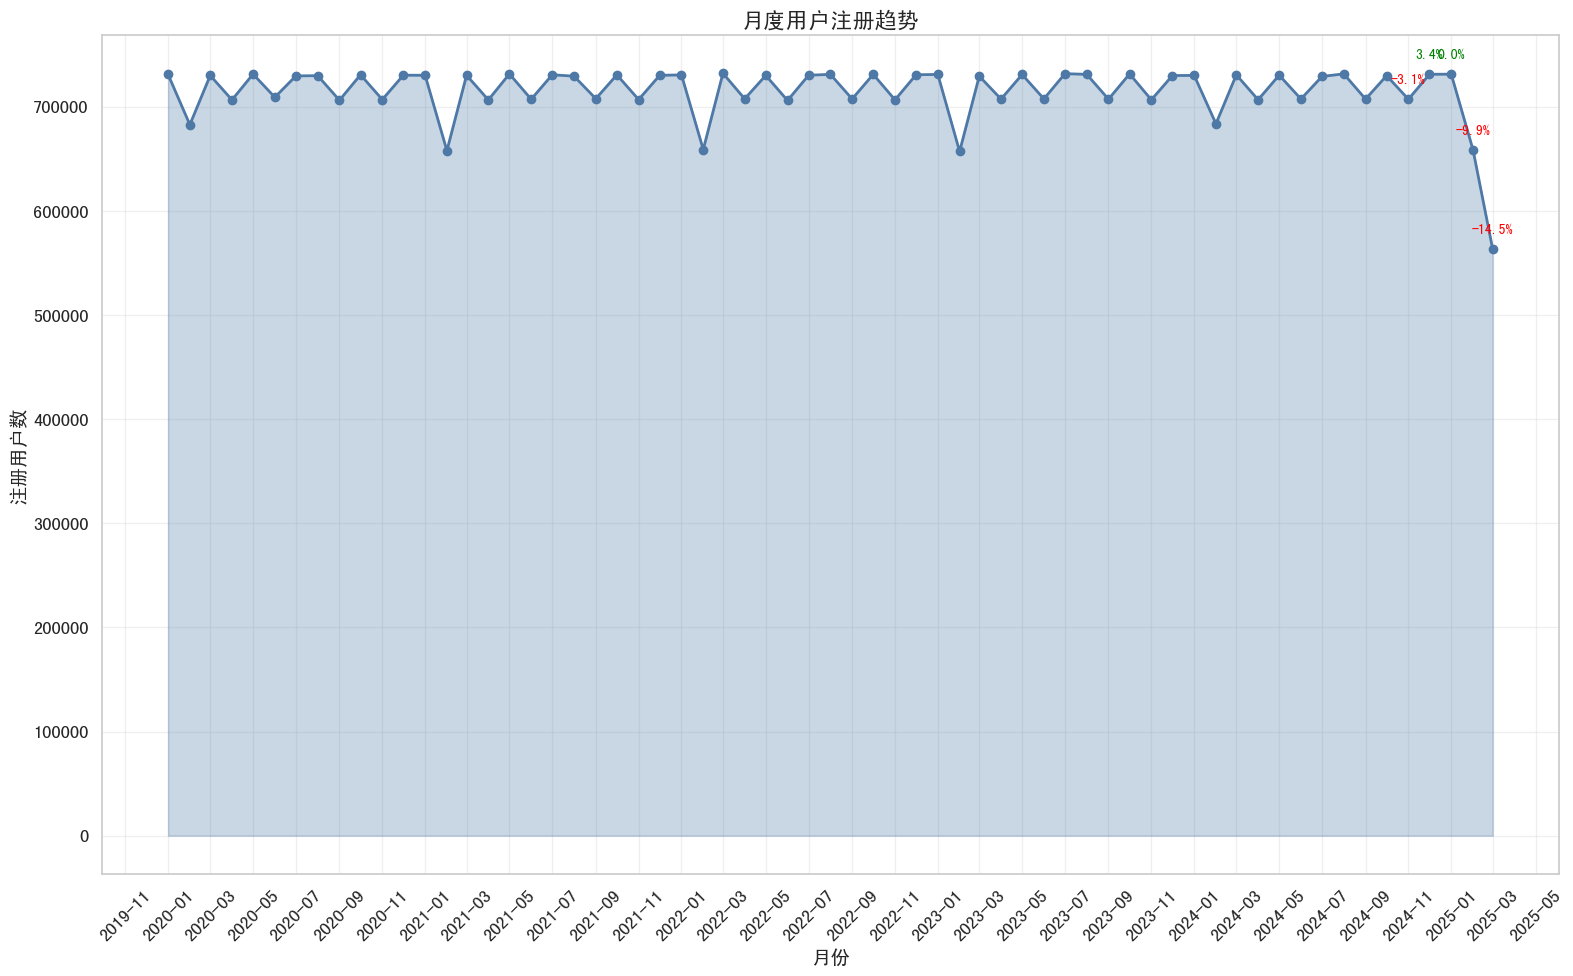

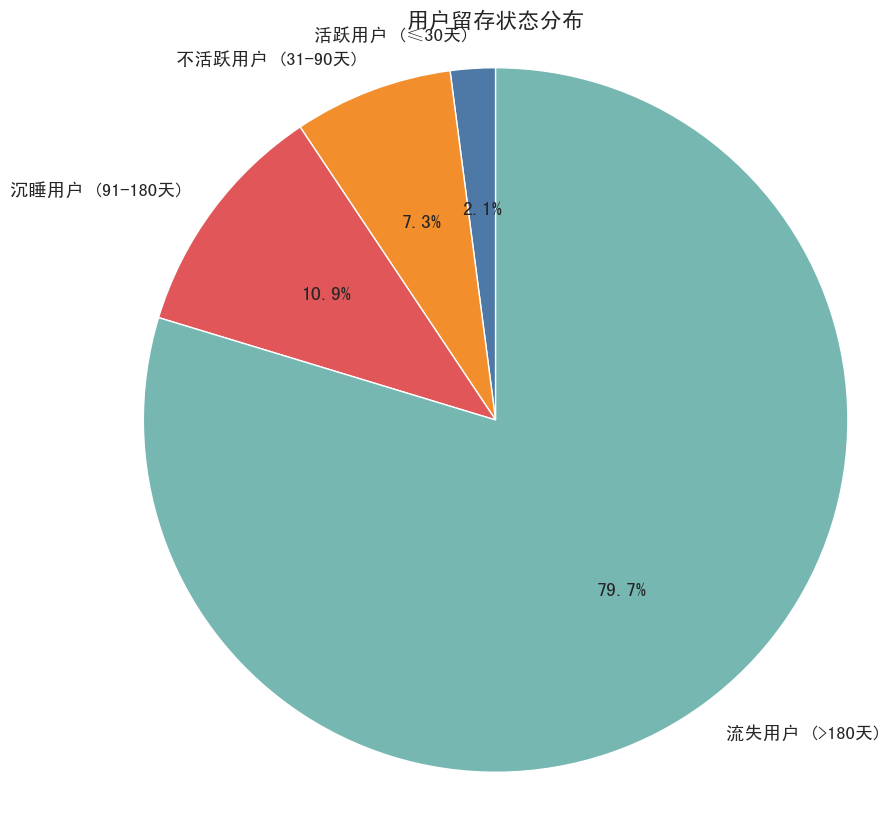

In [6]:
# 1.1.3 时间型变量分析
print("\n3. 分析时间型变量...")

# ---- 注册日期分析 ----
print("\n分析注册日期分布...")

# 按月聚合注册人数
monthly_registrations = df.withColumn("registration_month", 
                                    expr("date_format(registration_date, 'yyyy-MM')")) \
    .groupBy("registration_month") \
    .count() \
    .orderBy("registration_month") \
    .toPandas()

# 转换为时间序列数据
monthly_registrations["registration_month"] = pd.to_datetime(monthly_registrations["registration_month"])
monthly_registrations = monthly_registrations.sort_values("registration_month")

# 计算月环比增长率
monthly_registrations["mom_growth"] = monthly_registrations["count"].pct_change() * 100

# 计算同比增长率（假设数据至少有一年）
if len(monthly_registrations) >= 13:
    monthly_registrations["yoy_growth"] = monthly_registrations["count"].pct_change(12) * 100

print("月度注册用户数（最近5个月）：")
for idx, row in monthly_registrations.tail(5).iterrows():
    month_str = row["registration_month"].strftime("%Y-%m")
    print(f"- {month_str}: {row['count']:,} 用户", end="")
    if not np.isnan(row["mom_growth"]):
        print(f", 环比增长: {row['mom_growth']:.2f}%", end="")
    if 'yoy_growth' in monthly_registrations.columns and not np.isnan(row["yoy_growth"]):
        print(f", 同比增长: {row['yoy_growth']:.2f}%", end="")
    print()

# 绘制月度注册趋势图
plt.figure(figsize=(16, 10))
plt.plot(monthly_registrations["registration_month"], 
         monthly_registrations["count"], 
         marker='o', 
         linestyle='-', 
         color=PLOT_COLORS[0],
         linewidth=2)
plt.fill_between(monthly_registrations["registration_month"], 
                monthly_registrations["count"], 
                alpha=0.3, 
                color=PLOT_COLORS[0])

# 格式化x轴
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.xticks(rotation=45)

# 添加增长率标签（最近几个月）
for i in range(-5, 0):
    if i < -len(monthly_registrations):
        continue
    x = monthly_registrations["registration_month"].iloc[i]
    y = monthly_registrations["count"].iloc[i]
    if not np.isnan(monthly_registrations["mom_growth"].iloc[i]):
        mom = monthly_registrations["mom_growth"].iloc[i]
        plt.annotate(f"{mom:.1f}%", 
                    xy=(x, y), 
                    xytext=(0, 10),
                    textcoords='offset points',
                    ha='center',
                    va='bottom',
                    fontsize=10,
                    color='green' if mom >= 0 else 'red')

plt.grid(True, alpha=0.3)
plt.title('月度用户注册趋势', fontsize=16)
plt.xlabel('月份', fontsize=14)
plt.ylabel('注册用户数', fontsize=14)
plt.tight_layout()
plt.savefig(f"{output_dir}/monthly_registration_trend.png", dpi=300, bbox_inches="tight")

# ---- 最后登录分析 ----
print("\n分析最后登录时间...")
current_date = "2025-04-15"
# 计算用户留存情况
df = df.withColumn("days_since_login", 
                 datediff(to_date(lit(current_date)), col("last_login")))

retention_data = df.select(
    when(col("days_since_login") <= 30, "活跃用户 (≤30天)")
    .when(col("days_since_login") <= 90, "不活跃用户 (31-90天)")
    .when(col("days_since_login") <= 180, "沉睡用户 (91-180天)")
    .otherwise("流失用户 (>180天)").alias("retention_status")
).groupBy("retention_status").count().toPandas()

retention_total = retention_data["count"].sum()
retention_data["percentage"] = retention_data["count"] / retention_total * 100

# 按活跃度排序
retention_order = ["活跃用户 (≤30天)", "不活跃用户 (31-90天)", "沉睡用户 (91-180天)", "流失用户 (>180天)"]
retention_data["order"] = retention_data["retention_status"].apply(lambda x: retention_order.index(x) if x in retention_order else 999)
retention_data = retention_data.sort_values("order").reset_index(drop=True)

print("用户留存状态：")
for idx, row in retention_data.iterrows():
    print(f"- {row['retention_status']}: {row['count']:,} ({row['percentage']:.2f}%)")

# 分析流失用户的年龄和收入特征
churn_users = df.filter(col("days_since_login") > 180)
active_users = df.filter(col("days_since_login") <= 30)

churn_age_stats = churn_users.agg(
    avg("age").alias("avg_age"),
    expr("percentile_approx(age, 0.5)").alias("median_age")
).collect()[0]

active_age_stats = active_users.agg(
    avg("age").alias("avg_age"),
    expr("percentile_approx(age, 0.5)").alias("median_age")
).collect()[0]

churn_income_stats = churn_users.agg(
    avg("income").alias("avg_income"),
    expr("percentile_approx(income, 0.5)").alias("median_income")
).collect()[0]

active_income_stats = active_users.agg(
    avg("income").alias("avg_income"),
    expr("percentile_approx(income, 0.5)").alias("median_income")
).collect()[0]

print("\n流失用户 vs 活跃用户特征比较：")
print(f"- 平均年龄: 流失用户 {churn_age_stats['avg_age']:.2f} vs 活跃用户 {active_age_stats['avg_age']:.2f}")
print(f"- 中位年龄: 流失用户 {churn_age_stats['median_age']} vs 活跃用户 {active_age_stats['median_age']}")
print(f"- 平均收入: 流失用户 {churn_income_stats['avg_income']:.2f} vs 活跃用户 {active_income_stats['avg_income']:.2f}")
print(f"- 中位收入: 流失用户 {churn_income_stats['median_income']} vs 活跃用户 {active_income_stats['median_income']}")

# 绘制用户留存饼图
plt.figure(figsize=(10, 10))
plt.pie(retention_data["percentage"], 
       labels=retention_data["retention_status"], 
       autopct='%1.1f%%', 
       startangle=90, 
       colors=PLOT_COLORS[:len(retention_data)])
plt.axis('equal')
plt.title("用户留存状态分布", fontsize=16)
plt.savefig(f"{output_dir}/user_retention_pie.png", dpi=300, bbox_inches="tight")

# 按月统计最后登录时间（用于日历热力图）
login_heatmap_data = df.select(
    expr("year(last_login)").alias("year"),
    expr("month(last_login)").alias("month"),
    expr("dayofmonth(last_login)").alias("day")
).groupBy("year", "month", "day").count().toPandas()

# 创建日历热力图（简化版本 - 最近6个月）



4. 分析文本型变量...

分析购买历史...


购买历史统计：
- 总购买次数: 134,996,458
- 人均购买次数: 3.00
- 中位购买次数: 3
- 购买次数分位数 (25%, 75%, 90%, 95%, 99%): [2, 4, 5, 5, 5]

分析登录历史...


登录历史统计：
- 总登录次数: 562,506,950
- 人均登录次数: 12.50
- 中位登录次数: 13
- 登录次数分位数 (25%, 75%, 90%, 95%, 99%): [9, 17, 19, 20, 20]


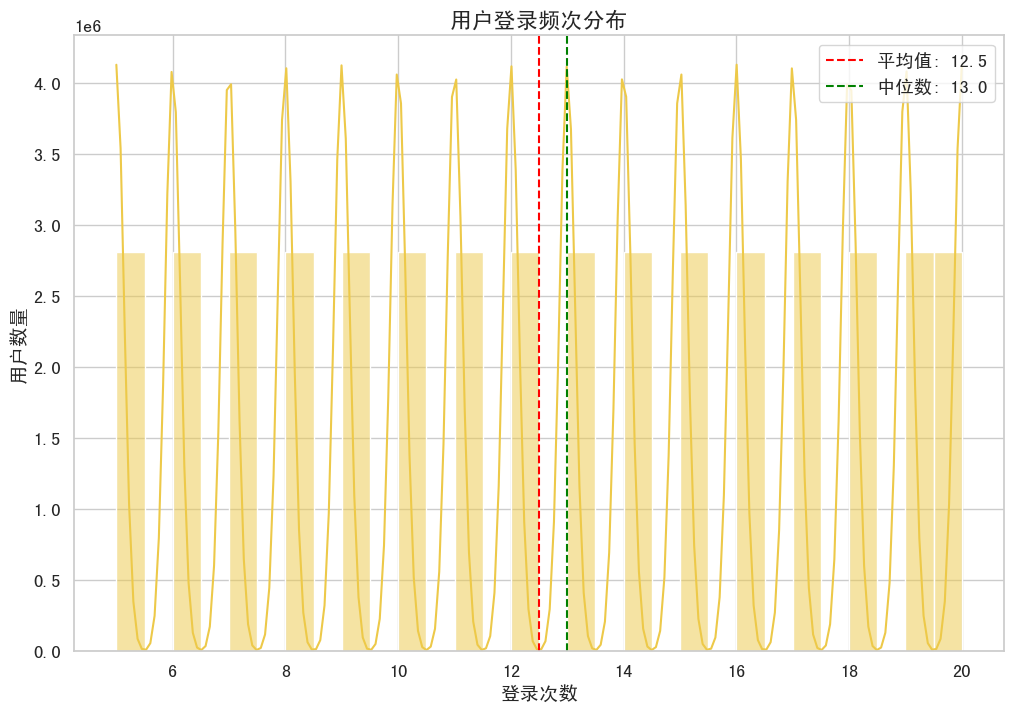

In [7]:
# 1.1.4 文本型变量分析
print("\n4. 分析文本型变量...")

# ---- 分析购买历史 ----
print("\n分析购买历史...")

# 假设购买历史是JSON数组，每个元素包含商品ID、时间、金额
# 这里我们使用UDF为每个用户计算购买总次数
def count_purchases(purchase_array):
    if not purchase_array:
        return 0
    return len(purchase_array)

count_purchases_udf = udf(count_purchases, IntegerType())
df = df.withColumn("purchase_count", count_purchases_udf(col("purchase_history_parsed")))

# 统计总购买次数和人均购买量
purchase_stats = df.agg(
    sum("purchase_count").alias("total_purchases"),
    avg("purchase_count").alias("avg_purchases_per_user"),
    expr("percentile_approx(purchase_count, 0.5)").alias("median_purchases_per_user"),
    expr("percentile_approx(purchase_count, array(0.25, 0.75, 0.9, 0.95, 0.99))").alias("purchase_percentiles")
).collect()[0]

print("购买历史统计：")
print(f"- 总购买次数: {purchase_stats['total_purchases']:,}")
print(f"- 人均购买次数: {purchase_stats['avg_purchases_per_user']:.2f}")
print(f"- 中位购买次数: {purchase_stats['median_purchases_per_user']}")
print(f"- 购买次数分位数 (25%, 75%, 90%, 95%, 99%): {purchase_stats['purchase_percentiles']}")

# 由于词云需要提取商品ID，我们可以采样一部分数据进行分析
# 注意：实际应用中应根据purchase_history的JSON格式正确解析

# ---- 分析登录历史 ----
print("\n分析登录历史...")

# 假设登录历史是JSON数组，每个元素是一个登录时间戳
# 这里我们使用UDF为每个用户计算登录总次数
def count_logins(login_array):
    if not login_array:
        return 0
    return len(login_array)

count_logins_udf = udf(count_logins, IntegerType())
df = df.withColumn("login_count", count_logins_udf(col("login_history_parsed")))

# 统计总登录次数和人均登录量
login_stats = df.agg(
    sum("login_count").alias("total_logins"),
    avg("login_count").alias("avg_logins_per_user"),
    expr("percentile_approx(login_count, 0.5)").alias("median_logins_per_user"),
    expr("percentile_approx(login_count, array(0.25, 0.75, 0.9, 0.95, 0.99))").alias("login_percentiles")
).collect()[0]

print("登录历史统计：")
print(f"- 总登录次数: {login_stats['total_logins']:,}")
print(f"- 人均登录次数: {login_stats['avg_logins_per_user']:.2f}")
print(f"- 中位登录次数: {login_stats['median_logins_per_user']}")
print(f"- 登录次数分位数 (25%, 75%, 90%, 95%, 99%): {login_stats['login_percentiles']}")
# 绘制登录频次分布图
login_freq = df.select("login_count").toPandas()
 
plt.figure(figsize=(12, 8))
sns.histplot(login_freq["login_count"].dropna(), kde=True, bins=30, color=PLOT_COLORS[5])
plt.title("用户登录频次分布", fontsize=16)
plt.xlabel("登录次数", fontsize=14)
plt.ylabel("用户数量", fontsize=14)
plt.axvline(login_freq["login_count"].dropna().mean(), color='red', linestyle='--', 
                label=f"平均值: {login_freq['login_count'].dropna().mean():.1f}")
plt.axvline(login_freq["login_count"].dropna().median(), color='green', linestyle='--', 
                label=f"中位数: {login_freq['login_count'].dropna().median():.1f}")
plt.legend()
plt.savefig(f"{output_dir}/login_frequency_distribution.png", dpi=300, bbox_inches="tight")


In [8]:
 # 1.2 多变量分析
print("\n开始多变量分析...")

# 1.2.1 相关性分析
print("\n1. 相关性分析...")
# ---- 数值变量间的相关性 ----
print("\n分析数值变量间的相关性...")

# 转换为Pandas进行相关性分析
numeric_distribution = df.select("age", "income", "purchase_count", "login_count") \
                    .na.drop() \
                    .toPandas()

numeric_distribution['age'] = pd.to_numeric(numeric_distribution['age'], errors='coerce')
numeric_distribution['income'] = pd.to_numeric(numeric_distribution['income'], errors='coerce')
numeric_distribution['purchase_count'] = pd.to_numeric(numeric_distribution['purchase_count'], errors='coerce')
numeric_distribution['login_count'] = pd.to_numeric(numeric_distribution['login_count'], errors='coerce')
numeric_distribution = numeric_distribution.dropna()
# 计算皮尔逊相关系数
correlation_matrix = numeric_distribution.corr(method='pearson')
print("数值变量相关性矩阵:")
print(correlation_matrix)

# 计算斯皮尔曼秩相关系数（非线性关系）
spearman_corr = numeric_distribution.corr(method='spearman')
print("\n斯皮尔曼秩相关系数 (age vs purchase_count):")
print(f"- 年龄与购买频次: {spearman_corr.loc['age', 'purchase_count']:.4f}")



开始多变量分析...

1. 相关性分析...

分析数值变量间的相关性...


数值变量相关性矩阵:
                     age    income  purchase_count  login_count
age             1.000000  0.000195       -0.000132    -0.000078
income          0.000195  1.000000        0.000054    -0.000082
purchase_count -0.000132  0.000054        1.000000    -0.000454
login_count    -0.000078 -0.000082       -0.000454     1.000000

斯皮尔曼秩相关系数 (age vs purchase_count):
- 年龄与购买频次: -0.0001



分析分类变量与数值变量的关系...


不同性别的收入差异:
- 男: 平均收入 499952.11, 中位收入 499857.40, 样本数 21603397
- 女: 平均收入 500029.41, 中位收入 499979.93, 样本数 21598086
- 未指定: 平均收入 499845.11, 中位收入 499238.40, 样本数 899652
- 其他: 平均收入 500454.25, 中位收入 500537.11, 样本数 898865


/tmp/ipykernel_1347337/3044561483.py:23: FutureWarning:                         

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="gender", y="income", data=gender_income_distribution, palette=PLOT_COLORS[:3])
/tmp/ipykernel_1347337/3044561483.py:23: UserWarning: 
The palette list has fewer values (3) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(x="gender", y="income", data=gender_income_distribution, palette=PLOT_COLORS[:3])



不同国家的收入情况 (前10国家):
- 中国: 平均收入 500160.89, 中位收入 500182.96, 样本数 4498337
- 印度: 平均收入 500117.73, 中位收入 500154.72, 样本数 4499562
- 法国: 平均收入 500075.20, 中位收入 500097.75, 样本数 4501427
- 德国: 平均收入 500045.92, 中位收入 499801.12, 样本数 4500370
- 英国: 平均收入 499968.32, 中位收入 499846.07, 样本数 4501669
- 日本: 平均收入 499957.85, 中位收入 499705.57, 样本数 4498695
- 巴西: 平均收入 499949.22, 中位收入 499879.79, 样本数 4500526
- 俄罗斯: 平均收入 499930.37, 中位收入 499800.44, 样本数 4499132
- 澳大利亚: 平均收入 499919.28, 中位收入 499798.27, 样本数 4499124
- 美国: 平均收入 499846.31, 中位收入 499741.21, 样本数 4501158


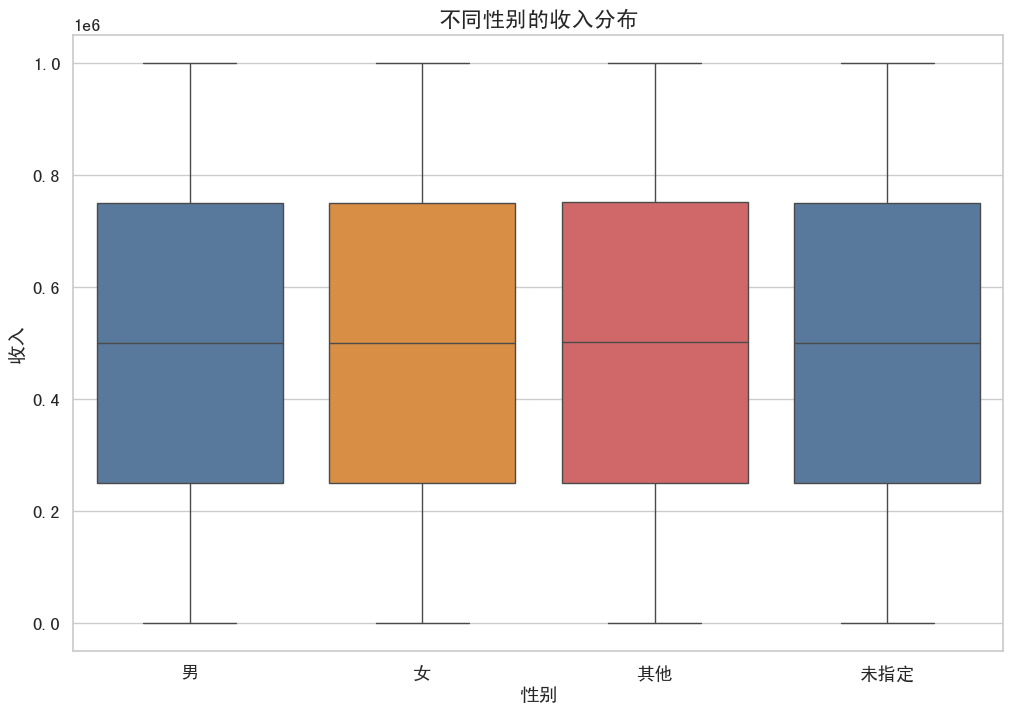

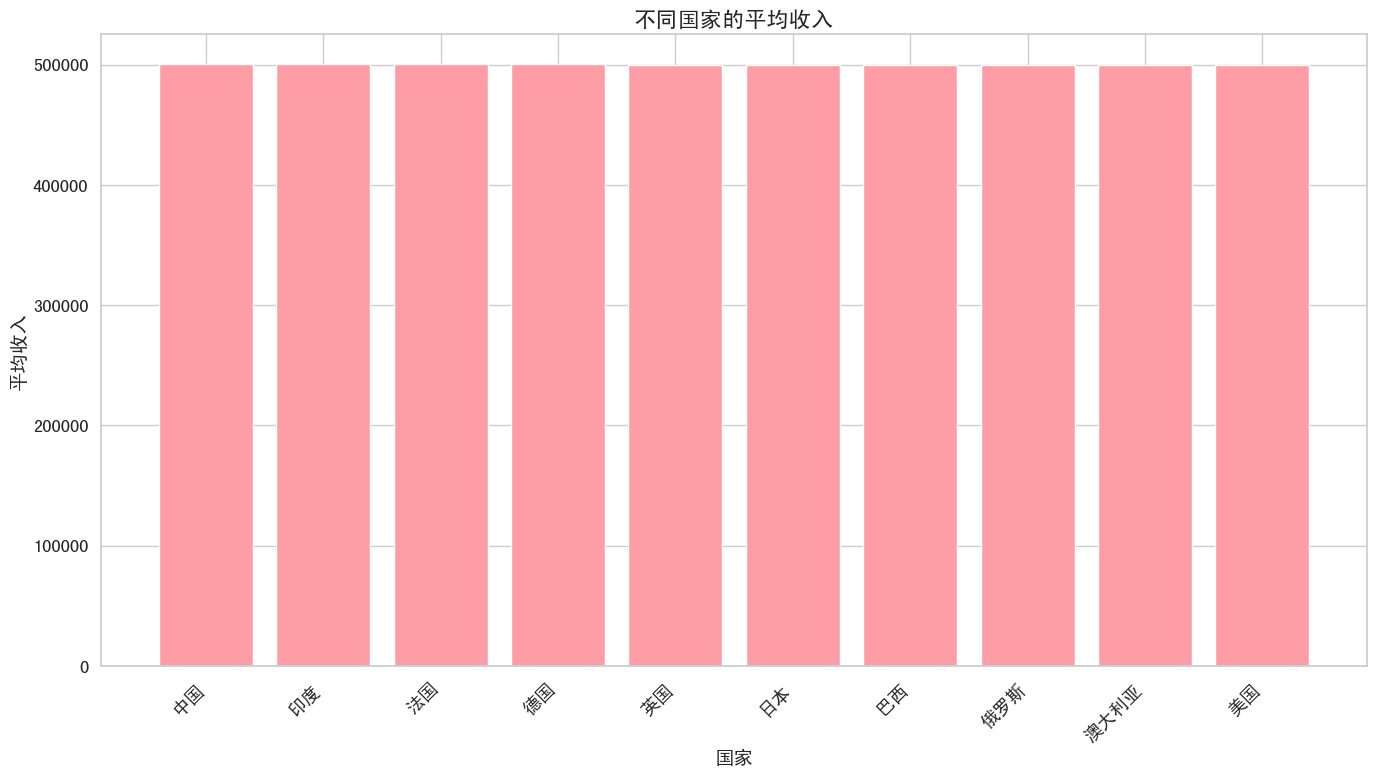

In [9]:
# ---- 分类变量与数值变量的关系 ----
print("\n分析分类变量与数值变量的关系...")

# 性别与收入的关系
gender_income = df.groupBy("gender") \
                  .agg(avg("income").alias("avg_income"),
                       expr("percentile_approx(income, array(0.25, 0.5, 0.75))").alias("income_quartiles"),
                       count("*").alias("count")) \
                  .orderBy("count", ascending=False) \
                  .toPandas()

print("不同性别的收入差异:")
for idx, row in gender_income.iterrows():
    quartiles = row["income_quartiles"]
    print(f"- {row['gender']}: 平均收入 {row['avg_income']:.2f}, 中位收入 {quartiles[1]:.2f}, 样本数 {row['count']}")

# 绘制性别与收入的箱线图对比
gender_income_distribution = df.select("gender", "income") \
                         .filter(col("gender").isNotNull()) \
                         .toPandas()

plt.figure(figsize=(12, 8))
sns.boxplot(x="gender", y="income", data=gender_income_distribution, palette=PLOT_COLORS[:3])
plt.title("不同性别的收入分布", fontsize=16)
plt.xlabel("性别", fontsize=14)
plt.ylabel("收入", fontsize=14)
plt.savefig(f"{output_dir}/gender_income_boxplot.png", dpi=300, bbox_inches="tight")

# 国家与收入的关系 (ANOVA检验)
country_counts = df.groupBy("country").count().orderBy("count", ascending=False).toPandas()
country_income = df.filter(col("country").isin([row["country"] for idx, row in country_counts.head(10).iterrows()])) \
                   .groupBy("country") \
                   .agg(avg("income").alias("avg_income"),
                        expr("percentile_approx(income, 0.5)").alias("median_income"),
                        count("*").alias("count")) \
                   .orderBy("avg_income", ascending=False) \
                   .toPandas()

print("\n不同国家的收入情况 (前10国家):")
for idx, row in country_income.iterrows():
    print(f"- {row['country']}: 平均收入 {row['avg_income']:.2f}, 中位收入 {row['median_income']:.2f}, 样本数 {row['count']}")

# 绘制国家与收入的条形图对比
plt.figure(figsize=(14, 8))
plt.bar(country_income["country"], country_income["avg_income"], color=PLOT_COLORS[7])
plt.title("不同国家的平均收入", fontsize=16)
plt.xlabel("国家", fontsize=14)
plt.ylabel("平均收入", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(f"{output_dir}/country_income_barplot.png", dpi=300, bbox_inches="tight")



分析时间变量与行为变量的关系...


注册月份对购买频次的影响 (最近5个月):
- 2024-06: 平均购买次数 3.002618249, 用户数 707343
- 2024-07: 平均购买次数 2.998913544, 用户数 728976
- 2024-08: 平均购买次数 3.001341102, 用户数 731488
- 2024-09: 平均购买次数 2.999910924, 用户数 707260
- 2024-10: 平均购买次数 3.001385436, 用户数 729734
- 2024-11: 平均购买次数 3.000439807, 用户数 707129
- 2024-12: 平均购买次数 3.000240744, 用户数 731068
- 2025-01: 平均购买次数 2.997178541, 用户数 731182
- 2025-02: 平均购买次数 3.000610405, 用户数 658579
- 2025-03: 平均购买次数 3.000735070, 用户数 563212


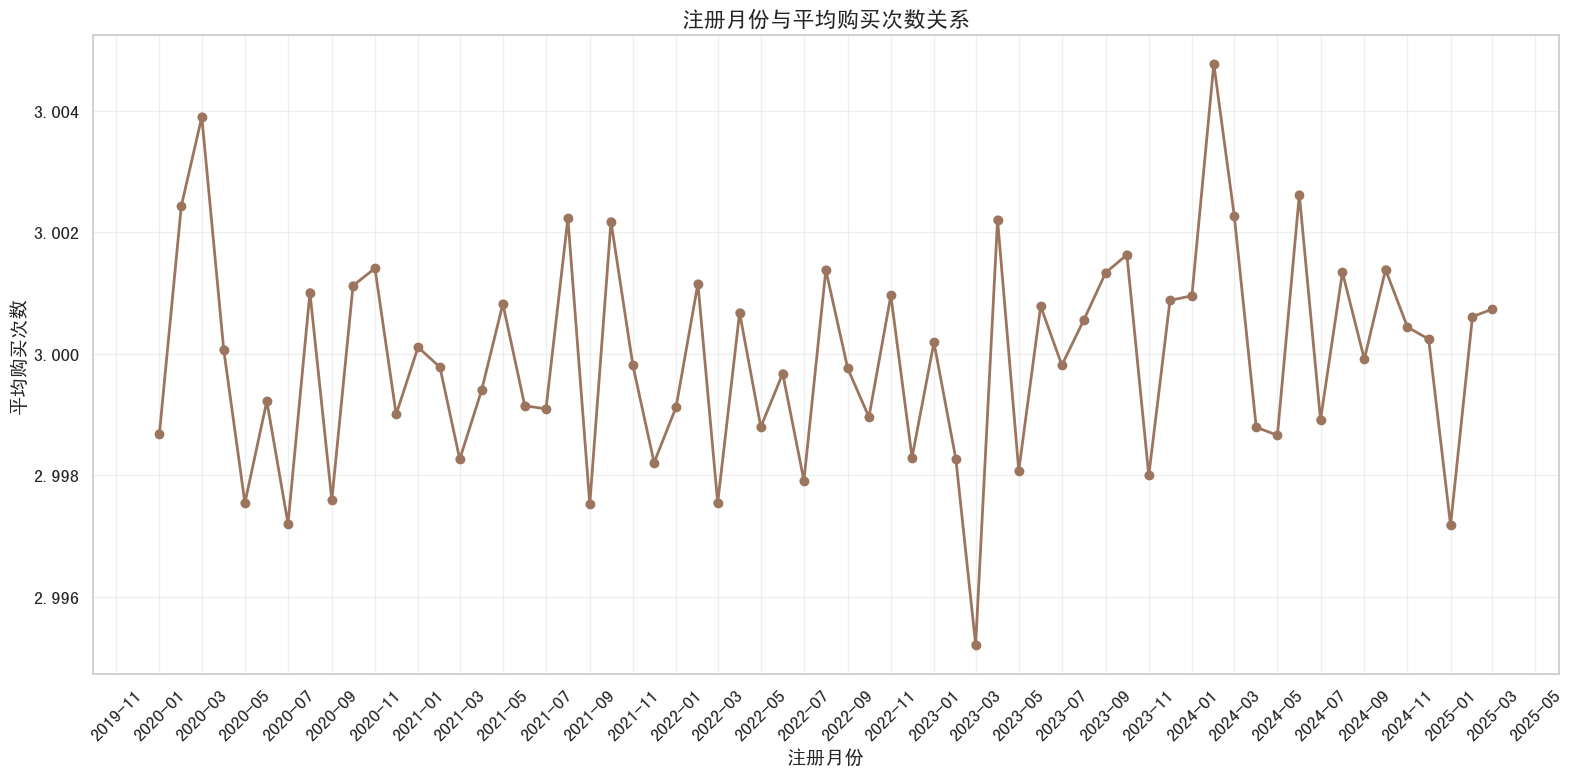

In [10]:
# ---- 时间变量与行为变量的关系 ----
print("\n分析时间变量与行为变量的关系...")

# 注册月份对购买频次的影响
registration_month_purchase = df.withColumn("registration_month", 
                                          expr("date_format(registration_date, 'yyyy-MM')")) \
                               .groupBy("registration_month") \
                               .agg(avg("purchase_count").alias("avg_purchases"),
                                    count("*").alias("user_count")) \
                               .orderBy("registration_month") \
                               .filter(col("user_count") > 1000) \
                               .toPandas()  # 过滤样本太少的月份

# 转换为时间序列数据
registration_month_purchase["registration_month"] = pd.to_datetime(registration_month_purchase["registration_month"])
registration_month_purchase = registration_month_purchase.sort_values("registration_month")

print("注册月份对购买频次的影响 (最近5个月):")
for idx, row in registration_month_purchase.tail(10).iterrows():
    month_str = row["registration_month"].strftime("%Y-%m")
    print(f"- {month_str}: 平均购买次数 {row['avg_purchases']:.9f}, 用户数 {row['user_count']}")

# 绘制注册月份与平均购买次数关系图
plt.figure(figsize=(16, 8))
plt.plot(registration_month_purchase["registration_month"], 
         registration_month_purchase["avg_purchases"], 
         marker='o', 
         linestyle='-', 
         color=PLOT_COLORS[8],
         linewidth=2)

# 添加用户数量作为点的大小
sizes = 30 * registration_month_purchase["user_count"] / registration_month_purchase["user_count"].max()
plt.scatter(registration_month_purchase["registration_month"],
            registration_month_purchase["avg_purchases"],
            s=sizes, 
            alpha=0.6,
            color=PLOT_COLORS[8])

# 格式化x轴
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.xticks(rotation=45)

plt.grid(True, alpha=0.3)
plt.title('注册月份与平均购买次数关系', fontsize=16)
plt.xlabel('注册月份', fontsize=14)
plt.ylabel('平均购买次数', fontsize=14)
plt.tight_layout()
plt.savefig(f"{output_dir}/registration_month_purchase.png", dpi=300, bbox_inches="tight")


2. 交叉分析...

分析国家与活跃状态的关系...


国家与活跃状态交叉表:
             非活跃       活跃     总用户数        活跃率
country                                      
巴西       2248966  2251560  4500526  50.028819
美国       2249858  2251300  4501158  50.016018
印度       2249435  2250127  4499562  50.007690
中国       2248954  2249383  4498337  50.004768
俄罗斯      2249541  2249591  4499132  50.000556
澳大利亚     2249923  2249201  4499124  49.991976
德国       2250771  2249599  4500370  49.986979
英国       2251666  2250003  4501669  49.981529
日本       2250365  2248330  4498695  49.977382
法国       2251829  2249598  4501427  49.975219

分析性别与购买行为的关系...


不同性别的购买行为:
- 男: 平均购买次数 3.00, 中位购买次数 3, 用户数 21603397
- 女: 平均购买次数 3.00, 中位购买次数 3, 用户数 21598086
- 未指定: 平均购买次数 3.00, 中位购买次数 3, 用户数 899652
- 其他: 平均购买次数 3.00, 中位购买次数 3, 用户数 898865


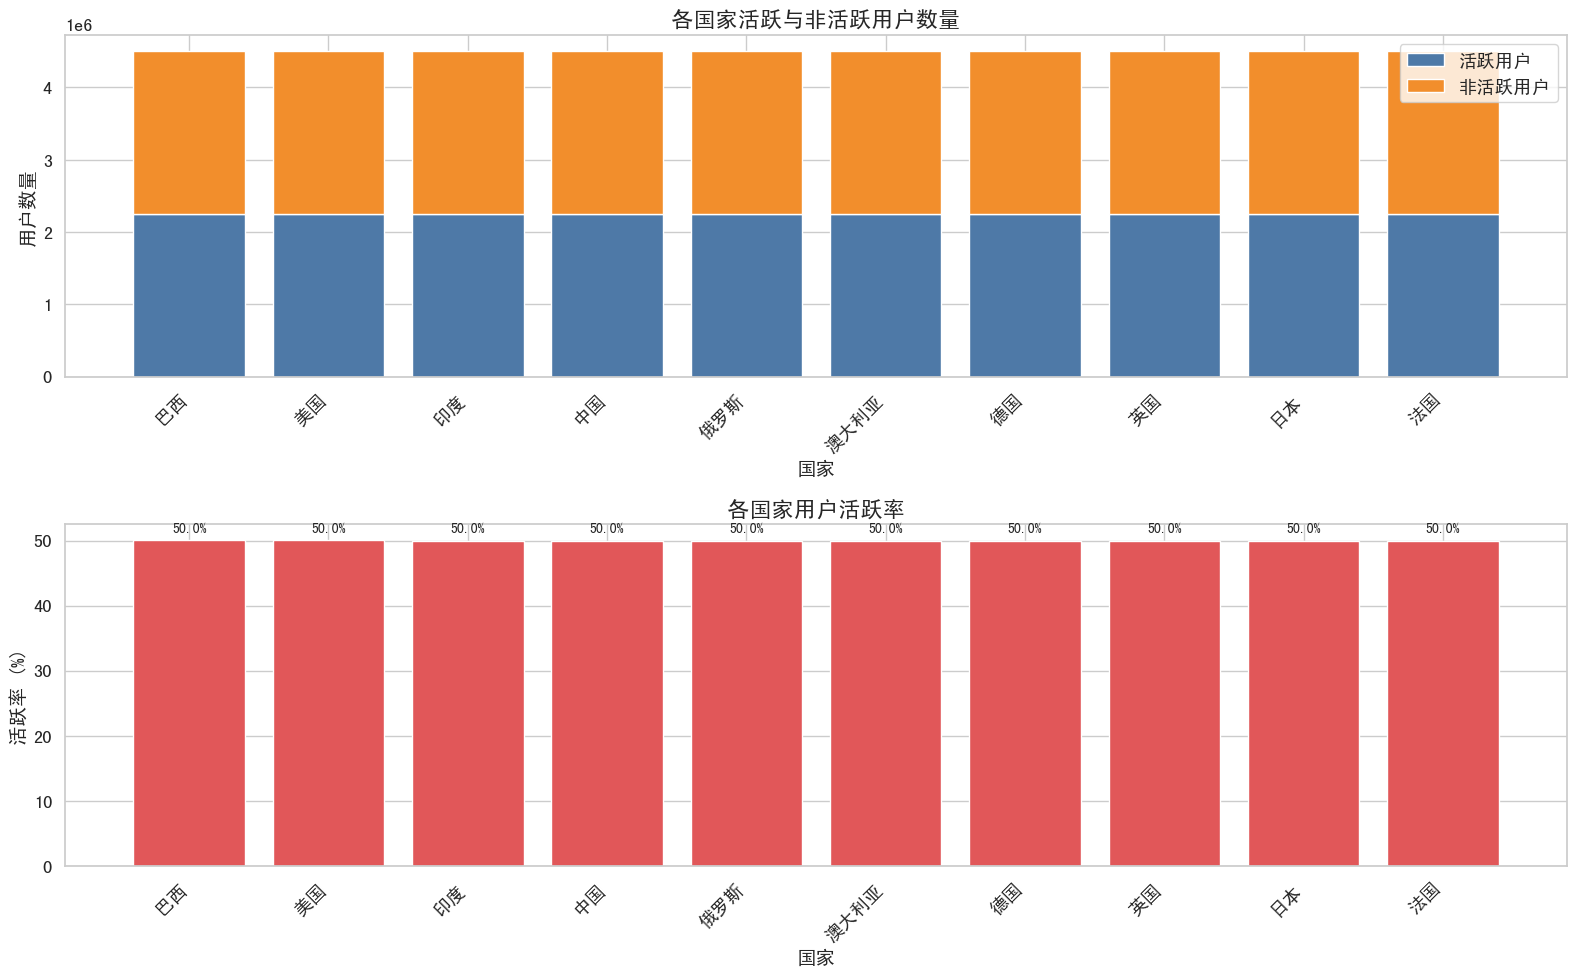

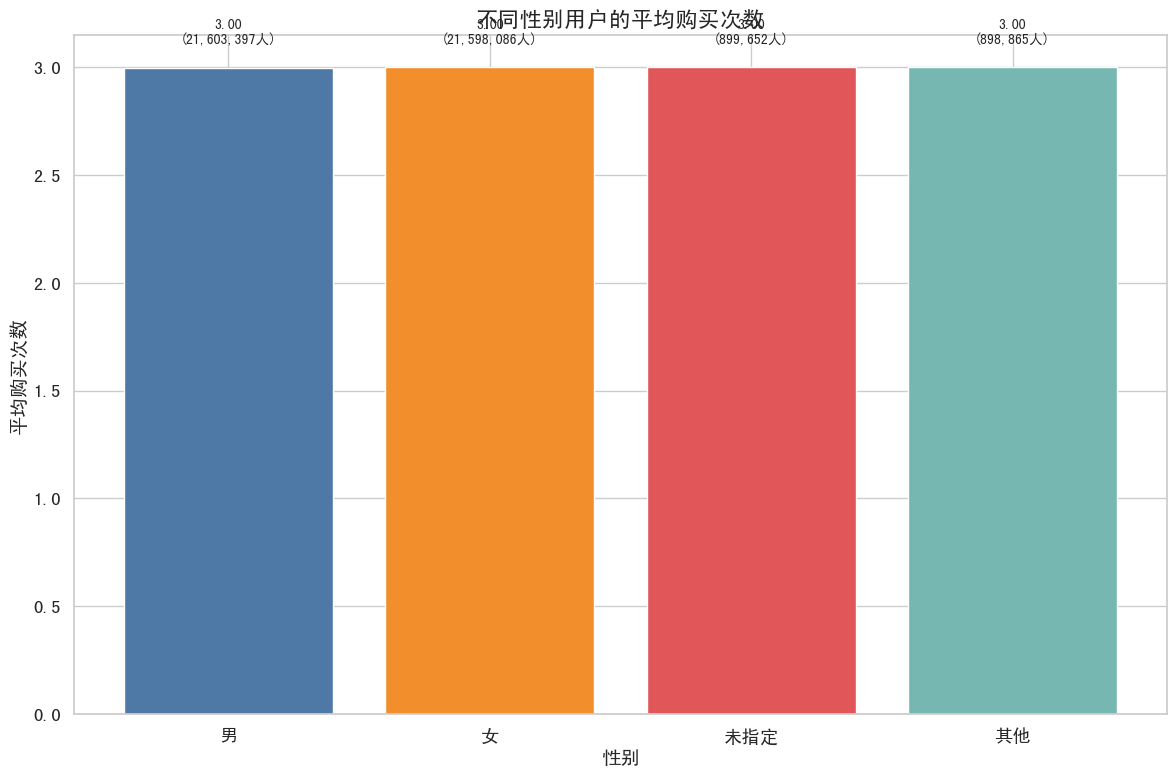

In [11]:
# 1.2.2 交叉分析
print("\n2. 交叉分析...")

# ---- 国家与活跃状态的交叉分析 ----
print("\n分析国家与活跃状态的关系...")

# 各国活跃用户占比(卡方检验需要原始数据)
country_active_cross = df.filter(col("country").isin([row["country"] for idx, row in country_counts.head(10).iterrows()])) \
                         .groupBy("country", "is_active") \
                         .count() \
                         .toPandas()
    
# 转换为交叉表
country_active_pivot = country_active_cross.pivot(index="country", columns="is_active", values="count").fillna(0)
country_active_pivot.columns = ["非活跃", "活跃"] if len(country_active_pivot.columns) == 2 else ["非活跃或缺失", "活跃或缺失"]
country_active_pivot["总用户数"] = country_active_pivot.sum(axis=1)
country_active_pivot["活跃率"] = country_active_pivot["活跃"] / country_active_pivot["总用户数"] * 100
country_active_pivot = country_active_pivot.sort_values("活跃率", ascending=False)

print("国家与活跃状态交叉表:")
print(country_active_pivot)

# 绘制国家与活跃状态的分面条形图
plt.figure(figsize=(16, 10))

countries = country_active_pivot.index.tolist()
active_rates = country_active_pivot["活跃率"].values
active_users = country_active_pivot["活跃"].values
inactive_users = country_active_pivot["非活跃"].values if "非活跃" in country_active_pivot.columns else country_active_pivot["非活跃或缺失"].values

# 排序
sorted_indices = np.argsort(active_rates)[::-1]
countries = [countries[i] for i in sorted_indices]
active_rates = [active_rates[i] for i in sorted_indices]
active_users = [active_users[i] for i in sorted_indices]
inactive_users = [inactive_users[i] for i in sorted_indices]

# 条形图
plt.subplot(2, 1, 1)
plt.bar(countries, active_users, label='活跃用户', color=PLOT_COLORS[0])
plt.bar(countries, inactive_users, bottom=active_users, label='非活跃用户', color=PLOT_COLORS[1])
plt.title('各国家活跃与非活跃用户数量', fontsize=16)
plt.xlabel('国家', fontsize=14)
plt.ylabel('用户数量', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend()

# 活跃率条形图
plt.subplot(2, 1, 2)
bars = plt.bar(countries, active_rates, color=PLOT_COLORS[2])
plt.title('各国家用户活跃率', fontsize=16)
plt.xlabel('国家', fontsize=14)
plt.ylabel('活跃率 (%)', fontsize=14)
plt.xticks(rotation=45, ha='right')

# 在条形上标注活跃率数值
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{active_rates[i]:.1f}%',
            ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig(f"{output_dir}/country_active_facet.png", dpi=300, bbox_inches="tight")

# ---- 性别与购买行为的交叉分析 ----
print("\n分析性别与购买行为的关系...")

# 不同性别用户的购买频次
gender_purchase = df.groupBy("gender") \
                    .agg(avg("purchase_count").alias("avg_purchases"),
                         expr("percentile_approx(purchase_count, 0.5)").alias("median_purchases"),
                         count("*").alias("user_count")) \
                    .orderBy("user_count", ascending=False) \
                    .toPandas()

print("不同性别的购买行为:")
for idx, row in gender_purchase.iterrows():
    print(f"- {row['gender']}: 平均购买次数 {row['avg_purchases']:.2f}, 中位购买次数 {row['median_purchases']}, 用户数 {row['user_count']}")

# 绘制性别与购买频次的条形图
plt.figure(figsize=(12, 8))

bars = plt.bar(gender_purchase["gender"], gender_purchase["avg_purchases"], color=PLOT_COLORS[:len(gender_purchase)])

# 在条形上标注购买次数和用户数
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{gender_purchase["avg_purchases"].iloc[i]:.2f}\n({gender_purchase["user_count"].iloc[i]:,}人)',
            ha='center', va='bottom', fontsize=10)

plt.title('不同性别用户的平均购买次数', fontsize=16)
plt.xlabel('性别', fontsize=14)
plt.ylabel('平均购买次数', fontsize=14)
plt.tight_layout()
plt.savefig(f"{output_dir}/gender_purchase_barplot.png", dpi=300, bbox_inches="tight")

In [5]:
#  第二部分：数据预处理 
print("开始数据预处理")

# 2.1 数据清洗
# 2.1.1 缺失值处理
print("检查缺失值")

from pyspark.sql.types import StringType

# 修改后的缺失值统计逻辑
def get_null_condition(col_name, col_type):
    """根据列类型生成不同的缺失值条件"""
    base_cond = col(col_name).isNull()
    if isinstance(col_type, StringType):
        return base_cond | (col(col_name) == '') | (col(col_name) == 'null') | (col(col_name) == 'NULL')
    else:
        return base_cond

# 生成每列的统计表达式
conditions = [count(when(get_null_condition(c, df.schema[c].dataType), c)).alias(c) 
              for c in df.columns]

# 执行缺失值统计
null_counts = df.select(conditions)

# 收集缺失值统计到驱动程序，转换为Pandas便于展示
null_counts_pd = null_counts.toPandas()
null_counts_pd = pd.melt(null_counts_pd, var_name='Column', value_name='NullCount')
null_counts_pd['TotalRows'] = df.count()
null_counts_pd['NullPercentage'] = (null_counts_pd['NullCount'] / null_counts_pd['TotalRows'] * 100).round(2)
null_counts_pd = null_counts_pd.sort_values('NullPercentage', ascending=False)

# 保存缺失值报告
null_counts_pd.to_csv(f"{output_dir}/missing_values_report.csv", index=False)
print("缺失值报告已保存到: missing_values_report.csv")

# 删除关键字段缺失的行
print("处理缺失值")
key_columns = ['user_name', 'email', 'id']
df_cleaned = df.dropna(subset=key_columns)

# 使用中位数填充age缺失值
age_median = df_cleaned.select(percentile_approx('age', 0.5)).collect()[0][0]
df_cleaned = df_cleaned.fillna({'age': age_median})

# 2.1.2 异常值处理
print("处理异常值")

# 处理年龄异常值
df_cleaned = df_cleaned.filter((col('age') >= 13) & (col('age') <= 100))

# 处理收入异常值 - 使用四分位数法检测异常值
income_stats = df_cleaned.select(
    percentile_approx('income', 0.25).alias('Q1'),
    percentile_approx('income', 0.75).alias('Q3')
).collect()[0]

Q1 = income_stats['Q1']
Q3 = income_stats['Q3']
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 使用窗口函数处理异常值
df_cleaned = df_cleaned.withColumn(
    'income_clean',
    when(col('income') < lower_bound, lower_bound)
    .when(col('income') > upper_bound, upper_bound)
    .otherwise(col('income').cast("float"))
)


开始数据预处理
检查缺失值


缺失值报告已保存到: missing_values_report.csv
处理缺失值


处理异常值


In [6]:
# 2.1.3 重复值处理
print("处理重复值...")

# 基于 ID 的唯一性检查
id_counts = df_cleaned.groupBy('id').count()
id_dup_count = id_counts.filter("count > 1").count()

if id_dup_count > 0:
    print(f"警告: 发现 {id_dup_count} 个重复的ID值")
    
    # 对于ID重复的情况，保留最新的记录
    window_spec_id = Window.partitionBy('id').orderBy(desc('registration_date'))
    df_cleaned = df_cleaned.withColumn('row_number', row_number().over(window_spec_id))
    id_to_remove = df_cleaned.filter(col('row_number') > 1).count()
    print(f"将删除 {id_to_remove} 条ID重复的记录")
    
    df_cleaned = df_cleaned.filter(col('row_number') == 1).drop('row_number')
    print(f"处理ID重复后的数据集大小: {df_cleaned.count()} 行")

# 基于用户名和电话号码的部分重复处理
user_phone_counts = df_cleaned.groupBy('user_name', 'phone_number').count()
user_phone_dup_count = user_phone_counts.filter("count > 1").count()
print(f"基于用户名和电话号码的重复记录组数: {user_phone_dup_count}")

if user_phone_dup_count > 0:
    # 对于同一用户名和电话的多条记录，保留最新注册的记录
    window_spec = Window.partitionBy('user_name', 'phone_number').orderBy(desc('registration_date'))
    df_cleaned = df_cleaned.withColumn('row_number', row_number().over(window_spec))
    
    # 统计将被删除的重复记录数
    to_be_removed = df_cleaned.filter(col('row_number') > 1).count()
    print(f"将删除 {to_be_removed} 条旧的用户记录")
    
    # 保留每组中最新的记录
    df_cleaned = df_cleaned.filter(col('row_number') == 1).drop('row_number')
    print(f"保留最新记录后的数据集大小: {df_cleaned.count()} 行")
else:
    print("没有基于用户名和电话号码的重复记录")

处理重复值...


基于用户名和电话号码的重复记录组数: 0
没有基于用户名和电话号码的重复记录


In [7]:
# 2.2 特征工程
print("开始特征工程...")

# 2.2.1 时间特征提取
print("提取时间特征...")
current_date = lit(datetime.now().strftime("%Y-%m-%d"))

# 注册时长特征
df_cleaned = df_cleaned.withColumn('registration_days', 
                                  datediff(current_date, col('registration_date')))

# 提取注册日期的年、月、季度、星期几
df_cleaned = df_cleaned.withColumn('reg_year', year(col('registration_date')))
df_cleaned = df_cleaned.withColumn('reg_month', month(col('registration_date')))
df_cleaned = df_cleaned.withColumn('reg_quarter', quarter(col('registration_date')))
df_cleaned = df_cleaned.withColumn('reg_dayofweek', dayofweek(col('registration_date')))

# 最近登录特征
df_cleaned = df_cleaned.withColumn('last_login_days', 
                                  datediff(current_date, col('last_login')))

# 2.2.2 行为特征构建 
print("构建行为特征...") 
from pyspark.sql.functions import size as array_size
import json

# 购买行为特征
# 提取类别特征 
def extract_purchase_categories(purchase_json):
    if not purchase_json or purchase_json == "null" or purchase_json == "":
        return []
    try:
        purchase_data = json.loads(purchase_json)
        if isinstance(purchase_data, dict) and 'categories' in purchase_data:
            return [purchase_data['categories']]
        return []
    except:
        return []

# 提取平均价格 
def extract_avg_purchase_amount(purchase_json):
    if not purchase_json or purchase_json == "null" or purchase_json == "":
        return 0.0
    try:
        purchase_data = json.loads(purchase_json)
        if isinstance(purchase_data, dict) and 'avg_price' in purchase_data:
            try:
                return float(purchase_data['avg_price'])
            except:
                return 0.0
        return 0.0
    except:
        return 0.0

# 注册UDF 
extract_categories_udf = udf(extract_purchase_categories, ArrayType(StringType())) 
extract_avg_amount_udf = udf(extract_avg_purchase_amount, DoubleType())

# 在DataFrame中添加特征 
df_cleaned = df_cleaned.withColumn('purchase_categories',
                                  extract_categories_udf(col('purchase_history'))) 
df_cleaned = df_cleaned.withColumn('category_count',
                                  array_size(col('purchase_categories'))) 
df_cleaned = df_cleaned.withColumn('avg_purchase_amount',
                                  extract_avg_amount_udf(col('purchase_history')))
# 登录行为特征
def calculate_login_frequency(login_array, days_since_registration):
    if not login_array or days_since_registration == 0:
        return 0.0
    return len(login_array) / (days_since_registration / 7)  # 周均登录次数

# 定义UDF
calc_login_freq_udf = udf(calculate_login_frequency, DoubleType())

# 计算周均登录频率
df_cleaned = df_cleaned.withColumn('weekly_login_frequency',
                                  calc_login_freq_udf(
                                      col('login_history_parsed'),
                                      col('registration_days')
                                  ))

# 2.2.3 分箱与离散化
print("特征分箱与离散化...")

# 年龄分箱
df_cleaned = df_cleaned.withColumn(
    'age_group',
    when(col('age') < 18, 'Under 18')
    .when((col('age') >= 18) & (col('age') <= 30), 'Young Adult (18-30)')
    .when((col('age') > 30) & (col('age') <= 50), 'Middle Age (31-50)')
    .when(col('age') > 50, 'Senior (51+)')
    .otherwise('Unknown')
)

# 收入分箱 - 使用分位数
income_quantiles = df_cleaned.select(
    percentile_approx('income_clean', array(lit(0.3), lit(0.7))).alias('quantiles')
).collect()[0]['quantiles']

low_income = income_quantiles[0]
high_income = income_quantiles[1]

df_cleaned = df_cleaned.withColumn(
    'income_group',
    when(col('income_clean') <= low_income, 'Low Income')
    .when((col('income_clean') > low_income) & (col('income_clean') <= high_income), 'Middle Income')
    .when(col('income_clean') > high_income, 'High Income')
    .otherwise('Unknown')
)

# 登录活跃度分箱
df_cleaned = df_cleaned.withColumn(
    'user_activity',
    when(col('last_login_days') <= 30, 'Active')
    .when((col('last_login_days') > 30) & (col('last_login_days') <= 90), 'Semi-Active')
    .when(col('last_login_days') > 90, 'Inactive')
    .otherwise('Unknown')
)


开始特征工程...
提取时间特征...
构建行为特征...
特征分箱与离散化...


In [8]:
# 2.2.4 编码与标准化
print("编码和标准化特征")

# 性别编码
print("性别编码")
df_cleaned = df_cleaned.withColumn(
    'gender_code',
    when(lower(col('gender')).isin(['male', 'm', '男', '男性']), 0)
    .when(lower(col('gender')).isin(['female', 'f', '女', '女性']), 1)
    .otherwise(2)  # 其他或未知
)

# 国家编码
print("国家编码")
top_countries = df_cleaned.groupBy('country').count().orderBy(desc('count'))
top_countries_list = [row['country'] for row in top_countries.collect()]

# 为每个国家创建单独的二元特征
for country in top_countries_list:
    col_name = f"country_{country.lower().replace(' ', '_')}"
    df_cleaned = df_cleaned.withColumn(
        col_name,
        when(col('country') == country, 1).otherwise(0)
    )

# 标准化数值特征
# 计算mean和std
print("标准化数值特征")
numeric_stats = df_cleaned.select(
    mean('income_clean').alias('income_mean'),
    stddev('income_clean').alias('income_std'),
    mean('age').alias('age_mean'),
    stddev('age').alias('age_std')
).collect()[0]

# 应用Z-score标准化
df_cleaned = df_cleaned.withColumn(
    'income_scaled',
    (col('income_clean') - lit(numeric_stats['income_mean'])) / lit(numeric_stats['income_std'])
)

df_cleaned = df_cleaned.withColumn(
    'age_scaled',
    (col('age') - lit(numeric_stats['age_mean'])) / lit(numeric_stats['age_std'])
)

# 计算活跃度分数 (结合登录频率和最后登录时间)
df_cleaned = df_cleaned.withColumn(
    'activity_score',(
    (1 / (1 + col('last_login_days'))) * (1 + col('weekly_login_frequency'))
    ).cast("float")
)

# 创建RFM分析特征
# R: Recency - 最近一次登录时间
# F: Frequency - 登录频率
# M: Monetary - 平均购买金额
df_cleaned = df_cleaned.withColumn(
    'rfm_score',
    (5 - when(col('last_login_days') <= 7, 5)
    .when(col('last_login_days') <= 30, 4)
    .when(col('last_login_days') <= 90, 3)
    .when(col('last_login_days') <= 180, 2)
    .otherwise(1)) * 100 +  # R score
    (when(col('weekly_login_frequency') >= 3, 5)
    .when(col('weekly_login_frequency') >= 2, 4)
    .when(col('weekly_login_frequency') >= 1, 3)
    .when(col('weekly_login_frequency') > 0, 2)
    .otherwise(1)) * 10 +  # F score
    (when(col('avg_purchase_amount') >= 100, 5)
    .when(col('avg_purchase_amount') >= 50, 4)
    .when(col('avg_purchase_amount') >= 20, 3)
    .when(col('avg_purchase_amount') > 0, 2)
    .otherwise(1))  # M score
)

# 分类用户价值
df_cleaned = df_cleaned.withColumn(
    'customer_value',
    when(col('rfm_score') >= 400, 'VIP')
    .when(col('rfm_score') >= 300, 'High Value')
    .when(col('rfm_score') >= 200, 'Medium Value')
    .otherwise('Low Value')
)
print("缓存处理后的数据集")

# 输出处理后的数据集基本统计信息
print(f"处理后的数据集大小: {df_cleaned.count()} 行, {len(df_cleaned.columns)} 列")
print("数据预处理完成!")

# 预处理结果样本展示
sample_processed = df_cleaned.limit(10)
sample_processed.show()

编码和标准化特征
性别编码
国家编码


标准化数值特征


缓存处理后的数据集


处理后的数据集大小: 45000000 行, 49 列
数据预处理完成!
+--------+----------+---------+--------+--------------------+---+---------+------+--------+-------------------------------+--------------------+---------+-----------------+-----------------+--------------------+-----------------------+--------------+--------------------+-----------+------------+-----------------+--------+---------+-----------+-------------+---------------+-------------------+--------------+-------------------+----------------------+-------------------+-------------+-------------+-----------+------------+------------+------------+------------+------------+------------+--------------+----------------+------------+------------+--------------------+-------------------+--------------+---------+--------------+
|      id|last_login|user_name|fullname|               email|age|   income|gender| country|                        address|    purchase_history|is_active|registration_date|     phone_number|       login_history|purchase_history_pars

In [ ]:
#识别潜在高价值用户
print("\n=== 3. 识别潜在高价值用户 ===")

# 3.1 特征选择
print("3.1 特征选择...")

# 选择用于聚类的特征，包括 'customer_value' 特征
cluster_features = ['income_clean', 'purchase_count', 'login_count', 'activity_score', 'customer_value']

# 确保选择的列都存在
for feature in cluster_features:
    if feature not in df_cleaned.columns:
        print(f"Warning: '{feature}' not found in dataframe columns. Available columns:")
        print(df_cleaned.columns)
        raise ValueError(f"Missing feature: {feature}")

# 使用 StringIndexer 转换 customer_value 列为数值类型
indexer = StringIndexer(inputCol="customer_value", outputCol="customer_value_index")
df_cleaned = indexer.fit(df_cleaned).transform(df_cleaned)
df_cleaned = df_cleaned.withColumn(
    "customer_value_index",
    col("customer_value_index").cast(ShortType())
)
# 更新 cluster_features 列表，使用 customer_value_index 代替 customer_value
cluster_features = ['income_clean', 'purchase_count', 'login_count', 'activity_score', 'customer_value_index']

# 为聚类分析准备数据
# 只选择完全没有空值的行进行聚类
cluster_data = df_cleaned.select(cluster_features).na.drop("any")

# 将Spark DataFrame转换为Pandas DataFrame (仅用于小规模可视化)
# 对于K-Means，我们使用Spark MLlib而不是转换为Pandas
print(f"聚类数据集大小: {cluster_data.count()} 行, {len(cluster_features)} 列")


=== 3. 识别潜在高价值用户 ===
3.1 特征选择...


聚类数据集大小: 45000000 行, 5 列


3.2 模型训练...
尝试K值 = 2


K=2, 成本=9.376083308294095e+17
尝试K值 = 3


K=3, 成本=4.168581844721921e+17
尝试K值 = 4


K=4, 成本=2.35370190377621e+17
尝试K值 = 5


K=5, 成本=1.6607866614276874e+17
尝试K值 = 6


K=6, 成本=1.0443751400576483e+17
尝试K值 = 7


K=7, 成本=7.860495078840595e+16
尝试K值 = 8


K=8, 成本=5.8831309657071176e+16
尝试K值 = 9


K=9, 成本=4.6727900852472184e+16
尝试K值 = 10


K=10, 成本=3.799188533630645e+16
肘部法则图已保存至 data_analysis_results/kmeans_elbow_method.png
选定最佳K值: 3


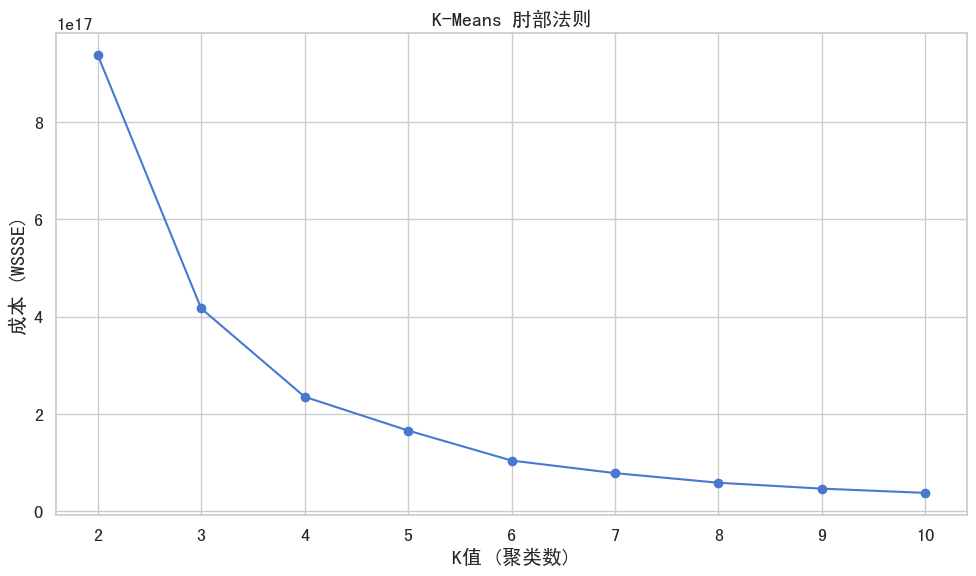

In [11]:
# 3.2模型训练
print("3.2 模型训练...")  

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.sql.functions import row_number, lit
from pyspark.sql.window import Window

# 创建向量特征
assembler = VectorAssembler(inputCols=cluster_features, outputCol="features")
vector_data = assembler.transform(cluster_data).repartition(400)  # 调整分区数量

# 将数据缓存到内存
vector_data.cache()

# 计算肘部法则以确定最佳K值
cost_values = []
k_values = range(2, 11)  # 尝试从2到10个集群

# 并行计算不同K值的成本
for k in k_values:
    print(f"尝试K值 = {k}")
    kmeans = KMeans(k=k, seed=42, maxIter=10, featuresCol="features")  # 降低迭代次数
    model = kmeans.fit(vector_data)
    cost = model.summary.trainingCost
    cost_values.append(cost)
    print(f"K={k}, 成本={cost}")

# 保存肘部法则图
pd_cost = pd.DataFrame({"K": list(k_values), "Cost": cost_values})
plt.figure(figsize=(10, 6))
plt.plot(pd_cost["K"], pd_cost["Cost"], marker="o")
plt.xlabel("K值 (聚类数)")
plt.ylabel("成本 (WSSSE)")
plt.title("K-Means 肘部法则")
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{output_dir}/kmeans_elbow_method.png")
print(f"肘部法则图已保存至 {output_dir}/kmeans_elbow_method.png")

# 根据肘部法则选择最佳K值
optimal_k = 3  # 根据上述图表结果调整
print(f"选定最佳K值: {optimal_k}")

# 使用最佳K值训练模型
final_kmeans = KMeans(k=optimal_k, seed=42, maxIter=10, featuresCol="features")  # 降低迭代次数
final_model = final_kmeans.fit(vector_data)

# 获取聚类结果
cluster_results = final_model.transform(vector_data)

# 将聚类结果添加回原始数据框
df_with_clusters = cluster_results.select("features", "prediction")
window_spec = Window.orderBy(lit(1))  # 创建一个窗口规范，用于保持行顺序
cluster_data_indexed = cluster_data.withColumn("row_id", row_number().over(window_spec))
df_with_clusters_indexed = df_with_clusters.withColumn("row_id", row_number().over(window_spec))

# 使用row_id连接回原始数据
df_clustered = cluster_data_indexed.join(
    df_with_clusters_indexed.select("row_id", "prediction"),
    "row_id"
)

# 删除辅助列
df_clustered = df_clustered.drop("row_id")


In [12]:
# 3.3 聚类结果解释
print("3.3 聚类结果解释...")

# 计算每个集群的大小
cluster_sizes = df_clustered.groupBy("prediction").count().orderBy("prediction")
print("集群大小统计:")
cluster_sizes.show()


# 计算每个集群的特征均值
cluster_stats = df_clustered.groupBy("prediction").agg(
    *[avg(col).alias(f"{col}_avg") for col in cluster_features]
)

print("\n集群特征均值:")
cluster_stats.show(truncate=False)

# 保存为CSV (使用Spark的写入功能)
# 注意：使用overwrite模式避免目录已存在错误
cluster_stats.coalesce(1).write.mode("overwrite").option("header", "true").csv(f"{output_dir}/cluster_statistics_spark")
print(f"集群统计数据已保存至 {output_dir}/cluster_statistics_spark")

# 收集聚类统计数据到驱动程序 
cluster_stats_pd = cluster_stats.toPandas()

# 定义描述性标签
# 根据特征均值为每个集群分配语义化标签
cluster_labels = {}
cluster_descriptions = {}

# 计算各特征的全局均值作为比较基准
mean_values = {
    'purchase_count_avg': cluster_stats_pd['purchase_count_avg'].mean(),
    'login_count_avg': cluster_stats_pd['login_count_avg'].mean(),
    'income_clean_avg': cluster_stats_pd['income_clean_avg'].mean(),
    'activity_score_avg': cluster_stats_pd['activity_score_avg'].mean()
}

# 计算各特征最大值用于归一化
max_values = {
    'income_clean_avg': cluster_stats_pd['income_clean_avg'].max(),
    'purchase_count_avg': cluster_stats_pd['purchase_count_avg'].max(),
    'login_count_avg': cluster_stats_pd['login_count_avg'].max(),
    'activity_score_avg': cluster_stats_pd['activity_score_avg'].max()
}

# 为每个集群生成标签和描述
for index, row in cluster_stats_pd.iterrows():
    cluster_id = int(row['prediction'])
    income = row['income_clean_avg']
    purchase = row['purchase_count_avg']
    login = row['login_count_avg']
    activity = row['activity_score_avg']
    
    # 创建评分系统，基于每个指标的相对值
    income_score = income / max_values['income_clean_avg'] if max_values['income_clean_avg'] > 0 else 0
    purchase_score = purchase / max_values['purchase_count_avg'] if max_values['purchase_count_avg'] > 0 else 0
    login_score = login / max_values['login_count_avg'] if max_values['login_count_avg'] > 0 else 0
    activity_score = activity / max_values['activity_score_avg'] if max_values['activity_score_avg'] > 0 else 0
    
    # 总体价值评分
    value_score = (income_score + purchase_score + login_score + activity_score) / 4
    
    # 基于评分分配标签
    if value_score > 0.7:
        label = "高价值用户"
    elif value_score > 0.4:
        label = "潜力用户"
    else:
        label = "流失风险用户"
    
    cluster_labels[cluster_id] = label
    
    # 创建文本描述
    description = f"集群 {cluster_id} ({label}):\n"
    description += f"  • 平均收入: {income:,.2f}\n"
    description += f"  • 平均购买次数: {purchase:.2f}\n"
    description += f"  • 平均登录次数: {login:.2f}\n"
    description += f"  • 平均活跃度评分: {activity:.6f}\n"
    
    # 添加行为特征描述
    purchase_desc = "高购买频率" if purchase > mean_values['purchase_count_avg'] else "低购买频率"
    login_desc = "高登录频率" if login > mean_values['login_count_avg'] else "低登录频率"
    income_desc = "高收入" if income > mean_values['income_clean_avg'] else "低收入"
    
    description += f"  • 特征组合: {income_desc} + {purchase_desc} + {login_desc}\n"
    
    # 添加营销建议
    if label == "高价值用户":
        description += "  • 营销建议: 提供VIP服务，保持忠诚度，推荐高端产品\n"
    elif label == "潜力用户":
        description += "  • 营销建议: 提供有针对性的促销，鼓励更多购买，升级用户体验\n"
    else:
        description += "  • 营销建议: 重新激活策略，提供特别优惠，改善用户体验\n"
    
    cluster_descriptions[cluster_id] = description

# 打印集群标签
print("\n集群标签:")
for cluster_id, label in cluster_labels.items():
    print(f"  集群 {cluster_id}: {label}")

# 将标签保存到文件
with open(f"{output_dir}/cluster_labels.json", "w") as f:
    json.dump(cluster_labels, f, ensure_ascii=False, indent=2)

# 打印集群描述
print("\n集群详细描述:")
for cluster_id, description in cluster_descriptions.items():
    print(description)

# 将集群描述保存到文件
with open(f"{output_dir}/cluster_descriptions.txt", "w") as f:
    for cluster_id, description in cluster_descriptions.items():
        f.write(description + "\n\n")

print(f"集群详细描述已保存至 {output_dir}/cluster_descriptions.txt")


# 创建可视化
print("\n生成可视化...")

3.3 聚类结果解释...
集群大小统计:


+----------+--------+
|prediction|   count|
+----------+--------+
|         0|15139090|
|         1|14860632|
|         2|15000278|
+----------+--------+


集群特征均值:


+----------+-----------------+------------------+------------------+--------------------+------------------------+
|prediction|income_clean_avg |purchase_count_avg|login_count_avg   |activity_score_avg  |customer_value_index_avg|
+----------+-----------------+------------------+------------------+--------------------+------------------------+
|0         |500051.4068076904|2.99961193176076  |12.498973386115017|0.005646809977384493|0.3063846638074019      |
|2         |500067.4292429893|3.000077665227271 |12.499719938523805|0.005649329641671116|0.3065253857295178      |
|1         |499870.7965187701|3.0000785969264294|12.501796222394848|0.005648878665929228|0.30639046845383155     |
+----------+-----------------+------------------+------------------+--------------------+------------------------+



集群统计数据已保存至 data_analysis_results/cluster_statistics_spark



集群标签:
  集群 0: 高价值用户
  集群 2: 高价值用户
  集群 1: 高价值用户

集群详细描述:
集群 0 (高价值用户):
  • 平均收入: 500,051.41
  • 平均购买次数: 3.00
  • 平均登录次数: 12.50
  • 平均活跃度评分: 0.005647
  • 特征组合: 高收入 + 低购买频率 + 低登录频率
  • 营销建议: 提供VIP服务，保持忠诚度，推荐高端产品

集群 2 (高价值用户):
  • 平均收入: 500,067.43
  • 平均购买次数: 3.00
  • 平均登录次数: 12.50
  • 平均活跃度评分: 0.005649
  • 特征组合: 高收入 + 高购买频率 + 低登录频率
  • 营销建议: 提供VIP服务，保持忠诚度，推荐高端产品

集群 1 (高价值用户):
  • 平均收入: 499,870.80
  • 平均购买次数: 3.00
  • 平均登录次数: 12.50
  • 平均活跃度评分: 0.005649
  • 特征组合: 低收入 + 高购买频率 + 高登录频率
  • 营销建议: 提供VIP服务，保持忠诚度，推荐高端产品

集群详细描述已保存至 data_analysis_results/cluster_descriptions.txt

生成可视化...


In [17]:
# 雷达图 - 显示各聚类的特征均值def create_radar_chart(stats_pd, labels, output_path):
def create_radar_chart(stats_pd, labels, output_path):
    # 准备特征列表和对应列名
    features = ['income_clean', 'purchase_count', 'login_count', 'activity_score']
    stat_columns = [f"{f}_avg" for f in features]
    
    # 数据标准化
    normalized_stats = stats_pd[stat_columns].apply(
        lambda x: (x - x.min()) / (x.max() - x.min()), 
        axis=0
    )
    
    # 设置雷达图参数
    num_vars = len(features)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # 闭合图形
    
    # 创建绘图
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(polar=True))
    
    # 绘制每个集群
    for idx, row in normalized_stats.iterrows():
        cluster_id = stats_pd.iloc[idx]['prediction']
        values = row.values.tolist()
        values += values[:1]  # 闭合图形
        
        ax.plot(angles, values, linewidth=2, 
                label=f"集群 {cluster_id}: {labels[cluster_id]}")
        ax.fill(angles, values, alpha=0.25)
    
    # 设置标签和样式
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([f.replace('_', ' ').title() for f in features])
    
    # 添加标题和图例
    plt.title("用户分群特征雷达图", y=1.1)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
    
    # 保存输出
    plt.tight_layout()
    plt.savefig(output_path, dpi=300)
    plt.close()
    print(f"雷达图已保存至 {output_path}")


In [18]:
# 创建可视化图表
cluster_stats_pd = cluster_stats.toPandas()

# 生成雷达图（使用集群统计数据）
create_radar_chart(
    stats_pd=cluster_stats_pd,
    labels=cluster_labels,
    output_path=f"{output_dir}/cluster_radar_chart.png"
)




雷达图已保存至 data_analysis_results/cluster_radar_chart.png


In [ ]:
# 将聚类预测结果添加回原始数据
# 使用聚类模型对有效数据打分
print("\n将聚类结果添加到原始数据框...")

# 为原始数据创建特征向量
original_vector_data = assembler.transform(df_cleaned.select(cluster_features).na.drop("any"))

# 使用聚类模型进行预测
original_predictions = final_model.transform(original_vector_data)

# 添加集群标签列
original_predictions = original_predictions.withColumn(
    "cluster_label", 
    when(col("prediction") == 0, lit(cluster_labels[0]))
    .when(col("prediction") == 1, lit(cluster_labels[1]))
    .when(col("prediction") == 2, lit(cluster_labels[2]))
    .otherwise(lit("未分类"))
)

# 为数据添加唯一索引列以便于后续合并
window_spec = Window.orderBy(lit(1))
original_predictions_indexed = original_predictions.withColumn("row_id", row_number().over(window_spec))
original_vector_data_indexed = original_vector_data.withColumn("row_id", row_number().over(window_spec))

# 合并原始数据与预测结果
df_with_original_predictions = original_vector_data_indexed.join(
    original_predictions_indexed.select("row_id", "prediction", "cluster_label"),
    on="row_id"
).drop("row_id")

print("\n高价值用户分析完成!")


将聚类结果添加到原始数据框...

聚类分析完成!
